# Assignment Overview


## Background Story  

In the ever-evolving landscape of e-commerce, understanding customer behavior has become a cornerstone of strategic marketing. An emerging e-commerce giant, "FarTrend," has experienced rapid growth by offering a wide range of products from fashion to electronics, catering to over 3400 customers across diverse demographics. Despite their success, FarTrend faces challenges in personalizing marketing efforts and predicting future purchasing behavior, crucial for sustaining growth and enhancing customer satisfaction.

## The Challenge

FarTrend's extensive customer database reveals purchasing patterns over the past year but lacks actionable insights to anticipate the needs of new customers. Traditional marketing strategies have yielded moderate success; however, the leadership team believes that a more data-driven approach could unlock exponential growth.

You are working on the marketing intelligence team! Your goal is to develop a  machine learning model that segments FarTrend's customer base and predicts future purchases of new customers within their first year. This model aims to transform FarTrend approach to customer engagement by delivering personalized marketing campaigns and tailored product recommendations.

## Data Description

The IT extracted a dataframe with the main transaction performed by the customers. 

##### Variables
InvoiceNo: Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name.

Quantity: The quantities of each product (item) per transaction. 

InvoiceDate: The day and time when each transaction was generated.

UnitPrice: Product price per unit.

CustomerID: Unique customer number. 

Country: The name of the country where each customer resides.

## Question 1: Data Quality and Customer Understanding (30 points)

#### Q1.1 Please perform the exploratory data analysis of the data. (20 points)

---
#### Imports and Data Loading

In [1]:
"""
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import SGDRegressor
import sklearn.metrics as metrics
"""

'\nfrom scipy.stats.mstats import winsorize\nfrom sklearn.preprocessing import QuantileTransformer, StandardScaler\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.feature_selection import RFE\nfrom sklearn.linear_model import SGDRegressor\nimport sklearn.metrics as metrics\n'

In [2]:
import warnings
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 50)
pd.set_option("display.float_format", "{:.2f}".format)

In [3]:
df_transactions_raw = pd.read_excel("FarTrend_eRetail.xlsx")
print("*" * 150 + "\ndf_transactions_raw:")
display(df_transactions_raw.head())
print("\nShape:", df_transactions_raw.shape)
print("\nDTypes:")
display(df_transactions_raw.dtypes)
print("\nBasic Stats:")
display(df_transactions_raw.describe())

******************************************************************************************************************************************************
df_transactions_raw:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom



Shape: (541909, 8)

DTypes:


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


Basic Stats:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.00,541909,541909.00,406829.00
mean,9.55,2011-07-04 13:34:57.156386048,4.61,15287.69
min,-80995.00,2010-12-01 08:26:00,-11062.06,12346.00
25%,1.00,2011-03-28 11:34:00,1.25,13953.00
50%,3.00,2011-07-19 17:17:00,2.08,15152.00
75%,10.00,2011-10-19 11:27:00,4.13,16791.00
max,80995.00,2011-12-09 12:50:00,38970.00,18287.00
std,218.08,NaN,96.76,1713.60


---
#### Data Quality Dimensions
In order to measure Data Quality in the multiple datasets, the following data quality dimensions will be considered:
1. **Completeness**: Data values are present;
    - Compute number of NaNs in the dataset, by column & row, total and percentages

2. **Consistency**:  Data satisfies constraints (format, allowable ranges and values, domain rules);
    - Evaluate Current Dtypes and Formats
    - Calculate the min, max, mean, and median values of numerical variables
    - Compute the value counts of categorical variables
    - Check the distribution, namely if it fits any distribution type and if it has excessive skewness and/or kurtosis; perform Shapiro-Wilk test
    - Compute Outliers (numerical variables)

3. **Uniqueness**: Records are not replicated;
    - Look for repeat entries based on the InvoiceNo and StockCode variables

4. **Timeliness**: Data is up-to-date to their real-world state for the task in hand;
    - Based on the InvoiceDate, check if the data refers to old transactions or current transactions
    
Other data quality dimensions - **Correctness**, **Stability**, **Relevance**, **Contextualization** and **Trustworthiness** - are either irrelevant or unfeasible to test, so we will assume they have good quality and no measures will be computed for them.

---
##### 1. Completeness
 - There is a significant number of NaNs in the CustomerID column, with almost a quarter of the dataset being affected. This can be a problem for the clustering and recommendation tasks in the following questions, so the problematic entries were inspected to look for a solution. It was found that whenever an entry as a NaN CustomerID, all other entries with the same InvoiceNo also have a NaN value, so we cannot solve the problem this way. Also, by doing a value counts for the InvoiceNo for the subset where CustomerID is NaN, we can observe that the value counts range from 1 to more than 1000 (with the majority being between 1 and 9 count). Based on all this information, we cannot use the affected rows of the dataset, so they will be dropped. The remaining dataset is still sizeable enough for the tasks planned.

  - A few rows have a NaN value in the Description column. When tested, it was found that some of the missing descriptions were in other entries of the dataset (entries with the same StockCode). We could just replace the missing information in these cases, but further tests show that all the problematic entries have a missing CustomerID and a price of 0, so they will be removed either way.

In [4]:
# Compute number of NaNs in the dataset, by column & row, total and percentages

def nan_stats(df: pd.DataFrame, print_output: bool = True) -> list:
    """
    Computes NaN statisitcs of 'df'
    
    Parameters
    ---------------
    df: pd.DataFrame
        Pandas dataframe used to compute the NaN statistics
    print_output: bool
        Boolean value with default value True, that determines whether
        the computed NaN statistics are printed when function is called
 
    Returns
    ---------------
    l_nan_stats: list
        A list with the NaN statistics. First position [0] will have the
        sum by column, second position [1] the number of rows with at
        least one NaN, third position [2] the percentage of rows with at
        least one NaN, forth [3] the total number of NaNs and fith [4]
        the percentage of NaN values in the dataframe
    
    """
    var_name = [name for name, value in globals().items() if value is df][0]
    temp_shape = df.shape
    temp_sum_col = df.isna().sum()
    temp_sum_row = sum(df.isna().sum(axis=1) > 0)
    temp_percent_row = round(100 * temp_sum_row / temp_shape[0], 2)
    temp_sum_all = temp_sum_col.sum()
    temp_percent_all = round(
        100 * temp_sum_all / (temp_shape[0] * temp_shape[1]), 2
    )

    if print_output:
        print("\n" + "*" * 150, "\nNaNs in {}:".format(var_name))
        display(temp_sum_col)
        print("Total Rows with NaNs:", temp_sum_row)
        print("Percentage of Rows with NaNs", str(temp_percent_row) + "%")
        print("Total NaNs:", temp_sum_all)
        print("Percentage of NaNs", str(temp_percent_all) + "%")

    l_nan_stats = [
        temp_sum_col, temp_sum_row, temp_percent_row, temp_sum_all,
        temp_percent_all
    ]

    return l_nan_stats

_, _, _, n_completeness_old, p_completeness_old = nan_stats(df_transactions_raw)


****************************************************************************************************************************************************** 
NaNs in df_transactions_raw:


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Total Rows with NaNs: 135080
Percentage of Rows with NaNs 24.93%
Total NaNs: 136534
Percentage of NaNs 3.15%


In [5]:
# Inspect the CustomerIDs with NaN, isolated and within the table context
df_temp_nan = df_transactions_raw[df_transactions_raw["CustomerID"].isna()]
print("*" * 150, "\nRows with CustomerID NaN:")
display(df_temp_nan)

# Add to the display the previous and next items
temp_index = np.array(df_temp_nan.index)
temp_index = np.concatenate([temp_index-1, temp_index, temp_index+1])
temp_index = np.unique(temp_index)
temp_index = temp_index[(temp_index >= 0) &
                        (temp_index <= df_transactions_raw.index.max())]
print("*" * 150, "\nRows with CustomerID NaN and Previous and Next Rows:")
display(df_transactions_raw.loc[temp_index].head())

# Check the InvoiceNo frequency within the CustomerID NaN subset
print("*" * 150, "\nInvoiceNo value counts in the CustomerID NaN subset:")
df_temp_vc = df_temp_nan["InvoiceNo"].value_counts()
display(df_temp_vc)
display(df_temp_vc.describe())

# Check any cases where entries with CustomerID NaN have the same InvoiceNo with an entry with CustomerID
print("*" * 150, "\nRows with common InvoiceNo in NaN subset:")
display(df_transactions_raw.loc[
        (df_transactions_raw["InvoiceNo"].isin(df_temp_nan["InvoiceNo"])) &
        (~df_transactions_raw["CustomerID"].isin(df_temp_nan["CustomerID"]))
])

del df_temp_nan, temp_index, df_temp_vc

****************************************************************************************************************************************************** 
Rows with CustomerID NaN:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


****************************************************************************************************************************************************** 
Rows with CustomerID NaN and Previous and Next Rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
621,536412,20750,RED RETROSPOT MINI CASES,1,2010-12-01 11:49:00,7.95,17920.00,United Kingdom
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
623,536415,22952,60 CAKE CASES VINTAGE CHRISTMAS,10,2010-12-01 11:57:00,0.55,12838.00,United Kingdom
1442,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841.00,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom


****************************************************************************************************************************************************** 
InvoiceNo value counts in the CustomerID NaN subset:


InvoiceNo
573585    1114
581219     749
581492     731
580729     721
558475     705
          ... 
551460       1
551461       1
551506       1
551538       1
556122       1
Name: count, Length: 3710, dtype: int64

count   3710.00
mean      36.41
std       96.10
min        1.00
25%        1.00
50%        1.00
75%        9.00
max     1114.00
Name: count, dtype: float64

****************************************************************************************************************************************************** 
Rows with common InvoiceNo in NaN subset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [6]:
# Inspect the cases where Description is NaN
print("*" * 150, "\nRows with Description NaN:")
df_temp_nan = df_transactions_raw[df_transactions_raw["Description"].isna()]
display(df_temp_nan)

# Check the StockCode frequency within the Description NaN subset
print("*" * 150, "\nStockCode value counts in the Description NaN subset:")
df_temp_vc = df_temp_nan["StockCode"].value_counts()
display(df_temp_vc)
display(df_temp_vc.describe())
print("Number of Unique StockCodes:", 
      df_temp_nan["StockCode"].unique().shape[0])

# Check any cases where entries with Description NaN have the same Stockcode with an entry with Description
print("*" * 150, "\nRows with common StockCode in NaN subset:")
df_temp_stock = df_transactions_raw.loc[
        (df_transactions_raw["StockCode"].isin(df_temp_nan["StockCode"])) &
        (~df_transactions_raw["Description"].isin(df_temp_nan["Description"]))
]
display(df_temp_stock)

# Display the rows where the StockCode always has NaN Description
df_temp_stock_nan = df_temp_nan.loc[
    ~df_temp_nan["StockCode"].isin(df_temp_stock["StockCode"])]
print("*" * 150, "\nRows where StockCode always has NaN Description:")
display(df_temp_stock_nan)
display(df_temp_stock_nan["StockCode"].value_counts())
display(df_temp_stock_nan["StockCode"].value_counts().describe())
print("Number of StockCodes that always have NaN Description:",
      df_temp_stock_nan["StockCode"].unique().shape[0])

# Check other problems in this subset - CustomerID NaN and UnitPrice 0
print("*" * 150, "\nOther Problems in the Nan Description Subset:")
print("CustomerID NaN percentage in NaN Description Subset:")
display(df_temp_nan[df_temp_nan["CustomerID"].isna()].shape[0] * 100\
        / df_temp_nan.shape[0])
print("UnitPrice = 0 percentage in the NaN Description Subset:")
display(df_temp_nan[df_temp_nan["UnitPrice"] == 0].shape[0] * 100\
        / df_temp_nan.shape[0])

del df_temp_nan, df_temp_vc, df_temp_stock, df_temp_stock_nan

****************************************************************************************************************************************************** 
Rows with Description NaN:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.00,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.00,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.00,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.00,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07 18:26:00,0.00,NaN,United Kingdom
535326,581203,23406,NaN,15,2011-12-07 18:31:00,0.00,NaN,United Kingdom
535332,581209,21620,NaN,6,2011-12-07 18:35:00,0.00,NaN,United Kingdom
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.00,NaN,United Kingdom


****************************************************************************************************************************************************** 
StockCode value counts in the Description NaN subset:


StockCode
35965     10
23084     10
22084      9
22451      6
22501      5
          ..
16169P     1
84846A     1
82545A     1
84251F     1
85175      1
Name: count, Length: 960, dtype: int64

count   960.00
mean      1.51
std       0.93
min       1.00
25%       1.00
50%       1.00
75%       2.00
max      10.00
Name: count, dtype: float64

Number of Unique StockCodes: 960
****************************************************************************************************************************************************** 
Rows with common StockCode in NaN subset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.00,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.00,United Kingdom
...,...,...,...,...,...,...,...,...
541858,581580,79321,CHILLI LIGHTS,2,2011-12-09 12:20:00,5.75,12748.00,United Kingdom
541874,581585,23084,RABBIT NIGHT LIGHT,12,2011-12-09 12:31:00,2.08,15804.00,United Kingdom
541879,581585,22726,ALARM CLOCK BAKELIKE GREEN,8,2011-12-09 12:31:00,3.75,15804.00,United Kingdom
541885,581585,21684,SMALL MEDINA STAMPED METAL BOWL,12,2011-12-09 12:31:00,0.85,15804.00,United Kingdom


****************************************************************************************************************************************************** 
Rows where StockCode always has NaN Description:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.00,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.00,NaN,United Kingdom
1988,536550,85044,NaN,1,2010-12-01 14:34:00,0.00,NaN,United Kingdom
2024,536552,20950,NaN,1,2010-12-01 14:34:00,0.00,NaN,United Kingdom
2026,536554,84670,NaN,23,2010-12-01 14:35:00,0.00,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
280754,561498,21610,NaN,-14,2011-07-27 14:10:00,0.00,NaN,United Kingdom
281615,561555,37477B,NaN,-11,2011-07-28 10:21:00,0.00,NaN,United Kingdom
281616,561557,37477C,NaN,-31,2011-07-28 10:21:00,0.00,NaN,United Kingdom
346849,567207,35592T,NaN,4,2011-09-19 11:01:00,0.00,NaN,United Kingdom


StockCode
21134     1
85226A    1
20863     1
84899F    1
10123G    1
         ..
84509F    1
84424A    1
35991     1
35644     1
84971L    1
Name: count, Length: 112, dtype: int64

count   112.00
mean      1.00
std       0.00
min       1.00
25%       1.00
50%       1.00
75%       1.00
max       1.00
Name: count, dtype: float64

Number of StockCodes that always have NaN Description: 112
****************************************************************************************************************************************************** 
Other Problems in the Nan Description Subset:
CustomerID NaN percentage in NaN Description Subset:


100.0

UnitPrice = 0 percentage in the NaN Description Subset:


100.0

In [7]:
# Remove the entries with NaN CustomerID
df_transactions_clean = df_transactions_raw.dropna(subset="CustomerID")

---
##### 2. Consistency
- Incorrect Dtypes/Format found: 
    - Some Invoice Numbers and Stock Codes are ints when they have only numbers, so we must convert to string

- min, max, mean and median values of numerical variables:
    - Some entries have negative quantity values, whenever the entry is from a returned invoice

    - Some entries have UnitPrice 0

    - There are some outliers in Quantity and UnitPrice in specific products, which were removed

    - Some products in the dataset are related to delivery and tax fees (e.g. Discount, CRUK)

- Value counts of categorical variables:
    - No out of the ordinary values.
    
- Distribution & Outliers:
    - Very Few outliers in  the data. Since the dataset has a great range of products,some by their nature will either be bought in higher quantities or sold at higher prices than the rest of the products, so we will assume that these outliers are part of the organic behavior of the sales, since it is not practical to plot a distribution for every product.

In [8]:
# Evaluate current dtypes and formats
print("df_transactions_clean:")
display(df_transactions_clean.dtypes)

# Check specific variables showing as 'object' in dtypes
def unique_types(df: pd.DataFrame, col: str) -> set:
    """
    Returns the unique dtypes in a Dataframe column
    
    Parameters
    ---------------
    df: pd.DataFrame
        Pandas dataframe with the column being evaluated
    col: str
        Name of the column evaluated
 
    Returns
    ---------------
    unique_types: set
        A set with the unique dtypes in the column
    
    """
    unique_types = {type(x) for x in df[col]}
    return unique_types

print("*" * 150)
print("InvoiceNo:", unique_types(df_transactions_clean, "InvoiceNo"))
print("StockCode:", unique_types(df_transactions_clean, "StockCode"))
print("Description:", unique_types(df_transactions_clean, "Description"))
print("Country:", unique_types(df_transactions_clean, "Country"))

df_transactions_clean:


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

******************************************************************************************************************************************************
InvoiceNo: {<class 'int'>, <class 'str'>}
StockCode: {<class 'int'>, <class 'str'>}
Description: {<class 'str'>}
Country: {<class 'str'>}


In [9]:
# Convert ints in InvoiceNo, StockCode and CustomerID to strings
df_transactions_clean["InvoiceNo"] = df_transactions_clean["InvoiceNo"].apply(
    lambda x: round(x) if (isinstance(x, int) or isinstance(x, float)) else x).astype(str)
df_transactions_clean["StockCode"] = df_transactions_clean["StockCode"].apply(
    lambda x: round(x) if (isinstance(x, int) or isinstance(x, float)) else x).astype(str)
df_transactions_clean["CustomerID"] = df_transactions_clean["CustomerID"].apply(
    lambda x: round(x) if (isinstance(x, int) or isinstance(x, float)) else x).astype(str)

display(df_transactions_clean.dtypes)
print("InvoiceNo:", unique_types(df_transactions_clean, "InvoiceNo"))
print("StockCode:", unique_types(df_transactions_clean, "StockCode"))
print("CustomerID:", unique_types(df_transactions_clean, "CustomerID"))

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

InvoiceNo: {<class 'str'>}
StockCode: {<class 'str'>}
CustomerID: {<class 'str'>}


In [10]:
# Calculate the min, max, mean, and median values of numerical variables
display(df_transactions_clean[["Quantity", "UnitPrice"]].describe())

,Quantity,UnitPrice
count,406829.00,406829.00
mean,12.06,3.46
std,248.69,69.32
min,-80995.00,0.00
25%,2.00,1.25
50%,5.00,1.95
75%,12.00,3.75
max,80995.00,38970.00


In [11]:
# Check abnormal Quantity values
# Check the observations with negative Quantity
print("*" * 150 + "\nNegative Quantities:")
display(df_transactions_clean[df_transactions_clean["Quantity"] < 0])
display(df_transactions_clean[
    (df_transactions_clean["Quantity"] < 0) & 
    (df_transactions_clean["InvoiceNo"].str.find("C") == -1)
])
print("*" * 150 + "\n Null Quantities:")
display(df_transactions_clean[df_transactions_clean["Quantity"] == 0])

print("*" * 150 + "\n Positive Quantities:")
df_temp_quantiles = pd.DataFrame(index=[0.75, 0.8, 0.85 , 0.9, 0.95, 0.99, 1])
df_temp_quantiles["Quantiles"] = df_temp_quantiles.index.map(lambda x: 
                                    df_transactions_clean["Quantity"].quantile(x))
display(df_temp_quantiles)

df_temp_q = df_transactions_clean[
    df_transactions_clean["Quantity"] >
    df_temp_quantiles.loc[0.99, "Quantiles"]
].sort_values("Quantity", ascending=False).drop_duplicates("StockCode")
display(df_temp_q.head(50))

del df_temp_quantiles

******************************************************************************************************************************************************
Negative Quantities:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


******************************************************************************************************************************************************
 Null Quantities:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


******************************************************************************************************************************************************
 Positive Quantities:


,Quantiles
0.75,12.00
0.80,12.00
0.85,18.00
0.90,24.00
0.95,36.00
0.99,120.00
1.00,80995.00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135,United Kingdom
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087,United Kingdom
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609,United Kingdom
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-04-18 13:20:00,2.10,15749,United Kingdom
433788,573995,16014,SMALL CHINESE STYLE SCISSOR,3000,2011-11-02 11:24:00,0.32,16308,United Kingdom
291249,562439,84879,ASSORTED COLOUR BIRD ORNAMENT,2880,2011-08-04 18:06:00,1.45,12931,United Kingdom


******************************************************************************************************************************************************
PAPER CRAFT , LITTLE BIRDIE:


count       2.00
mean    80995.00
std         0.00
min     80995.00
25%     80995.00
50%     80995.00
75%     80995.00
max     80995.00
Name: Quantity, dtype: float64

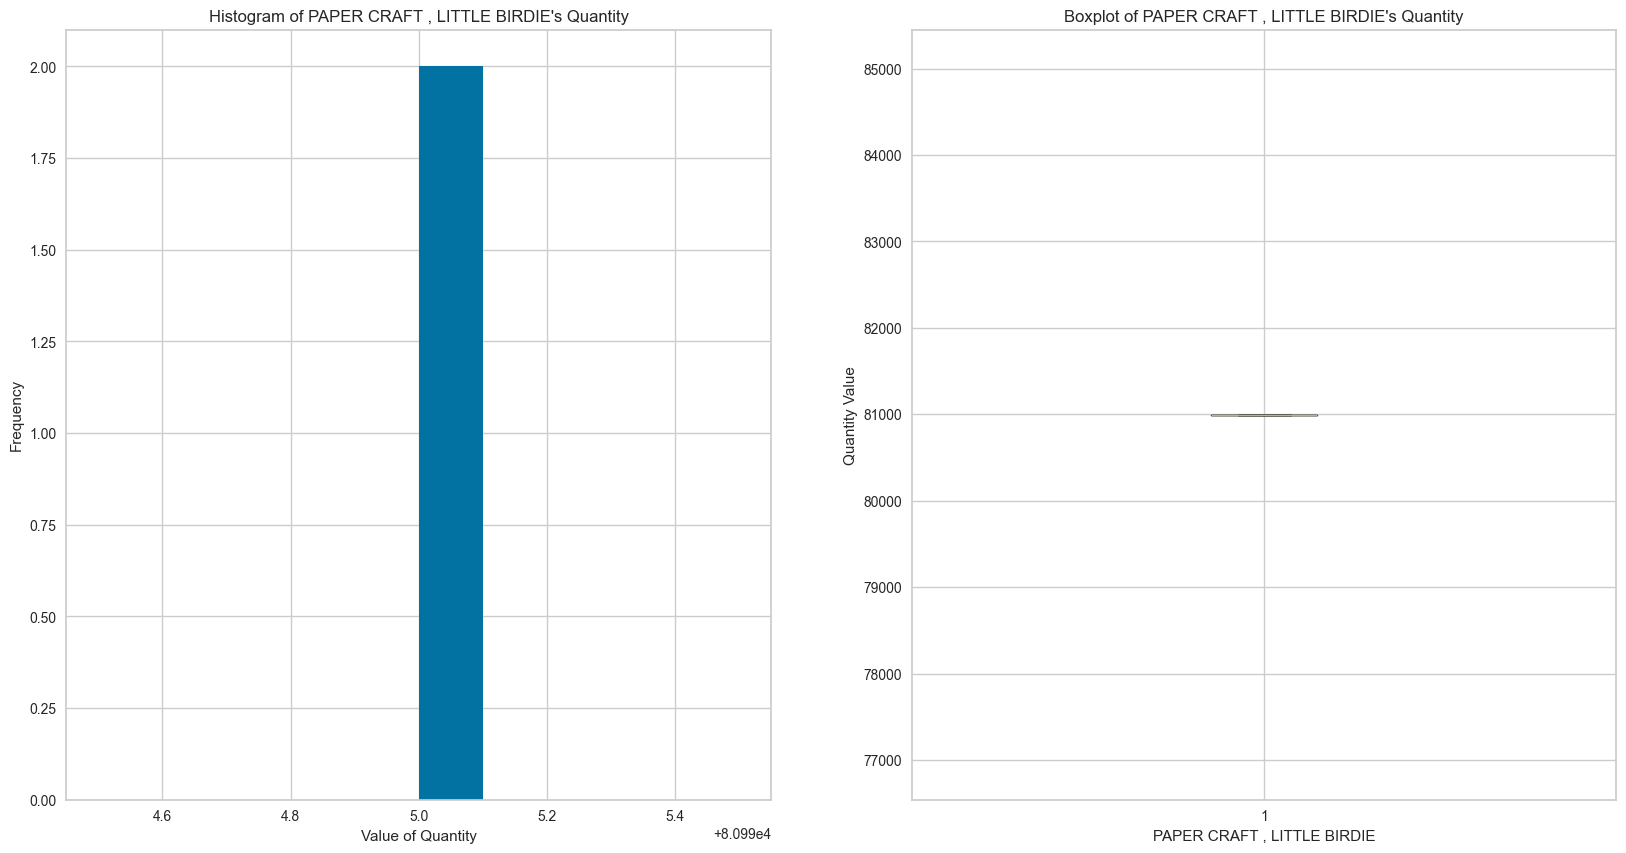

******************************************************************************************************************************************************
MEDIUM CERAMIC TOP STORAGE JAR:


count     208.00
mean      732.74
std      7257.98
min         1.00
25%         4.00
50%        12.00
75%        12.00
max     74215.00
Name: Quantity, dtype: float64

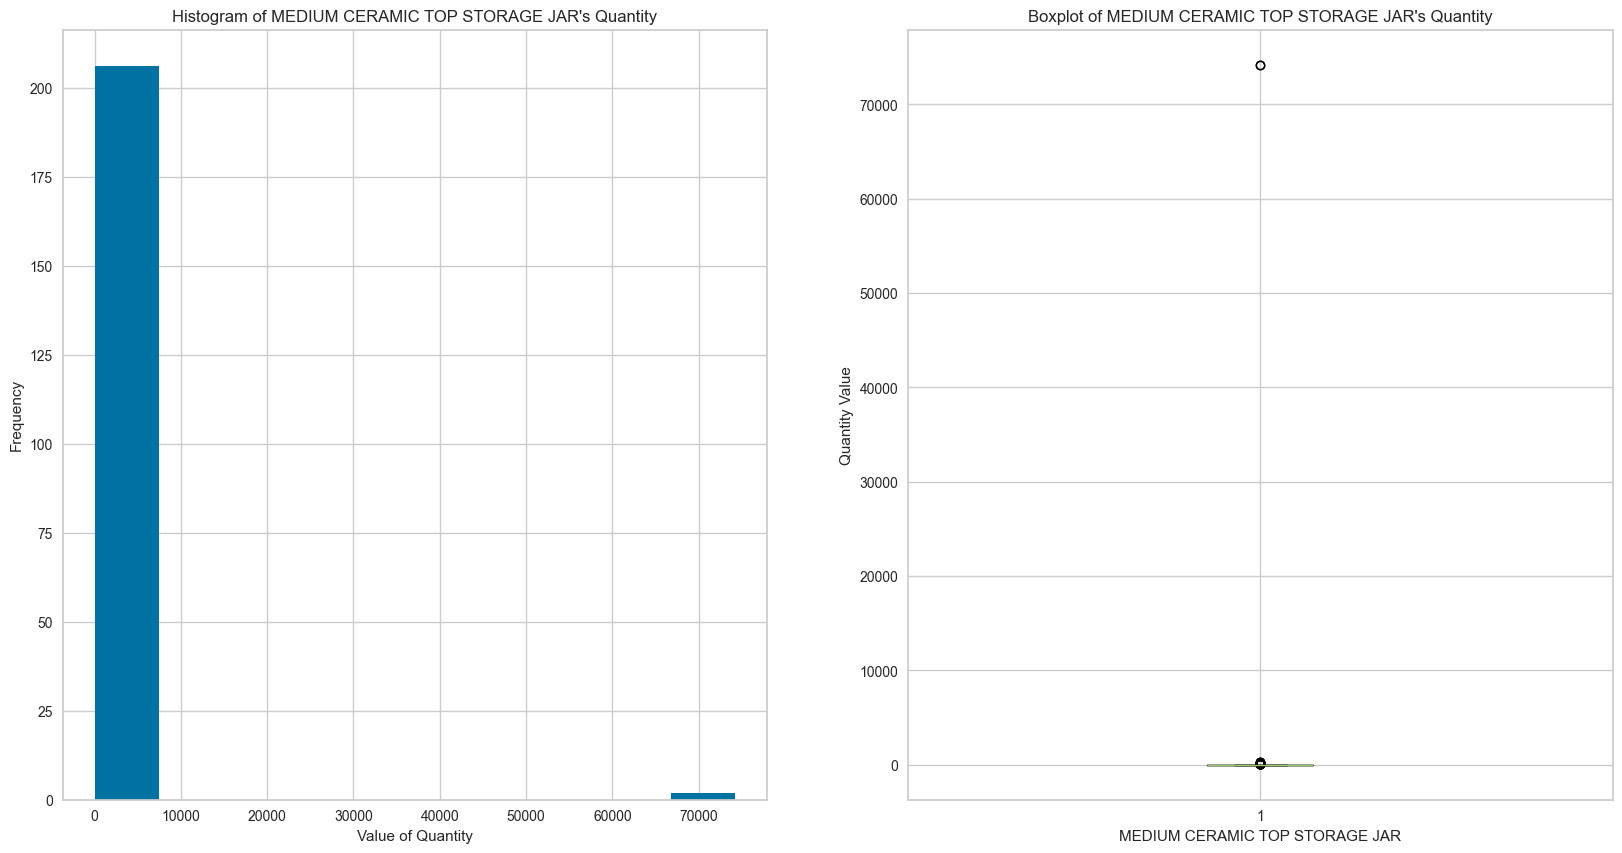

******************************************************************************************************************************************************
ASSTD DESIGN 3D PAPER STICKERS:


count      37.00
mean      371.95
std      2056.22
min         1.00
25%         2.00
50%        60.00
75%        60.00
max     12540.00
Name: Quantity, dtype: float64

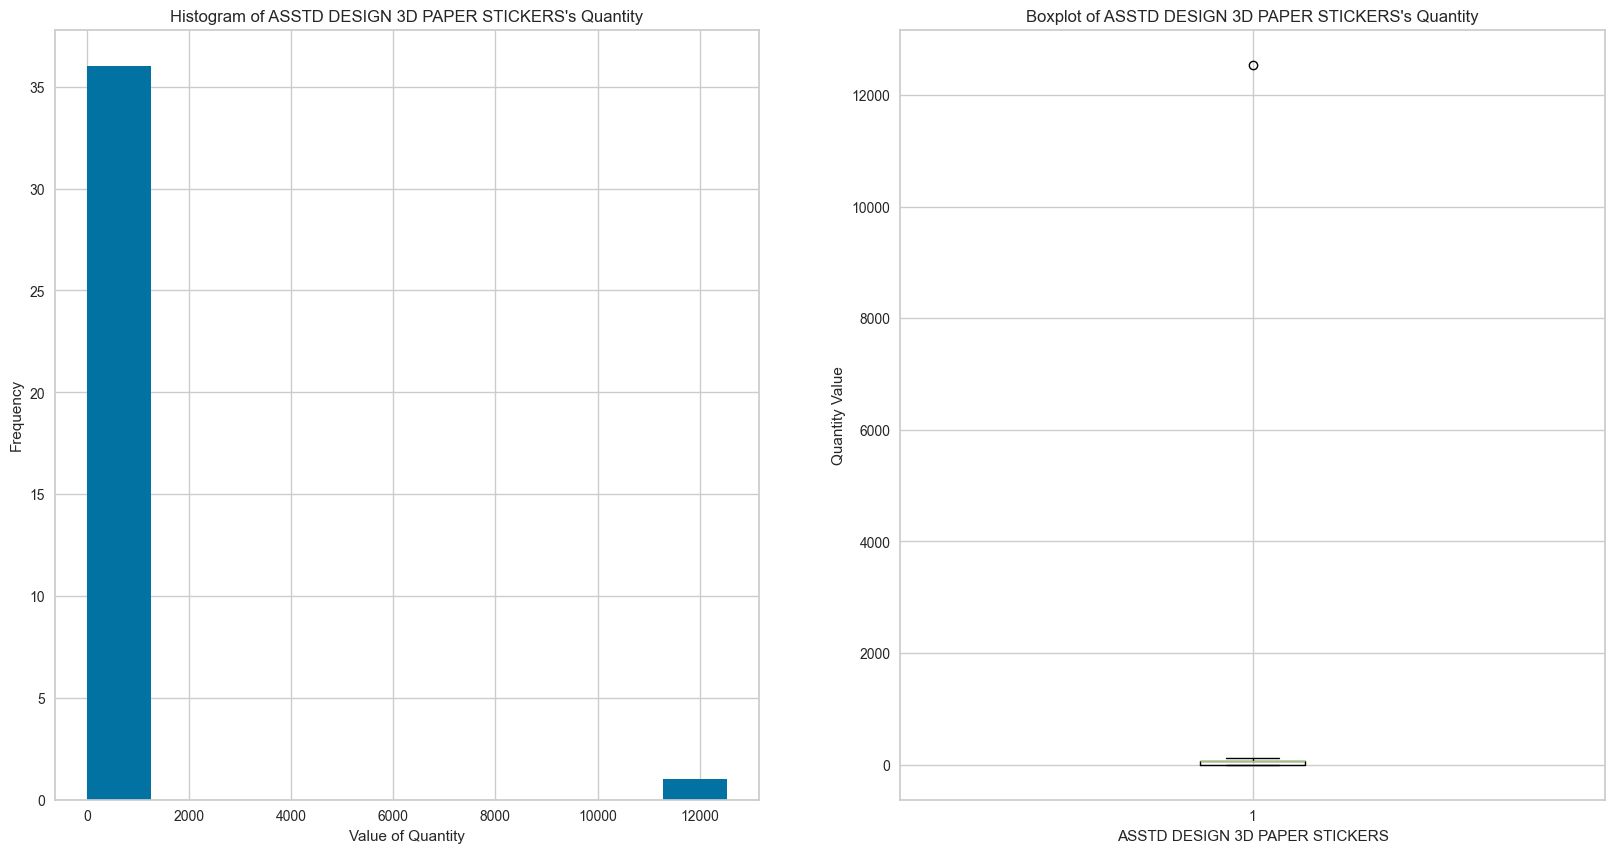

******************************************************************************************************************************************************
WORLD WAR 2 GLIDERS ASSTD DESIGNS:


count    478.00
mean     116.35
std      324.53
min        1.00
25%       48.00
50%       48.00
75%       48.00
max     4800.00
Name: Quantity, dtype: float64

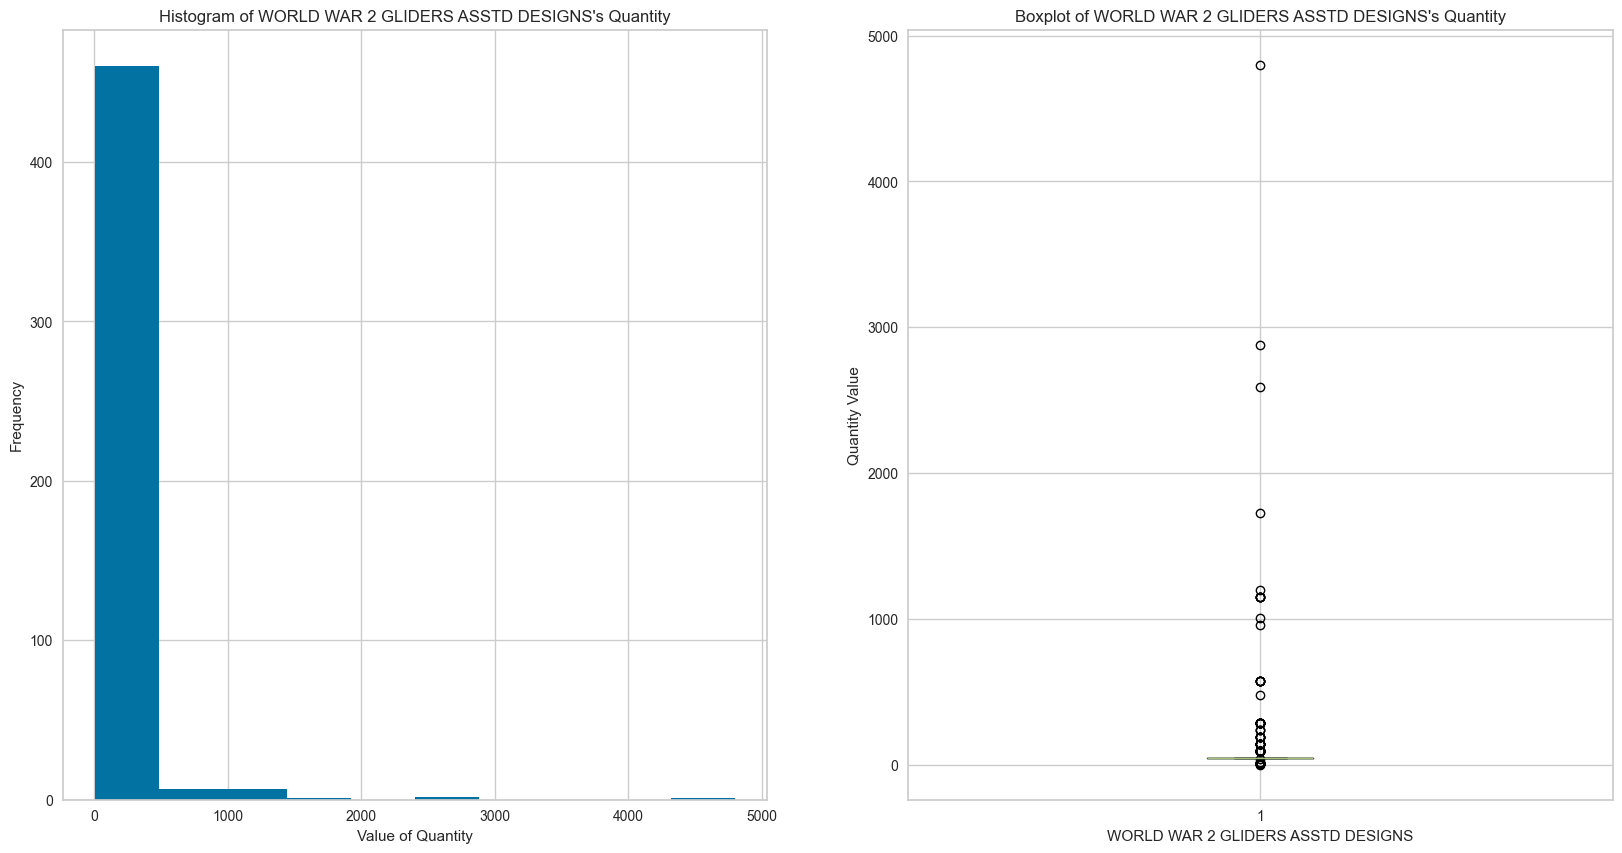

******************************************************************************************************************************************************
SMALL POPCORN HOLDER:


count   1118.00
mean      44.41
std      181.60
min        1.00
25%        5.00
50%       12.00
75%       24.00
max     4300.00
Name: Quantity, dtype: float64

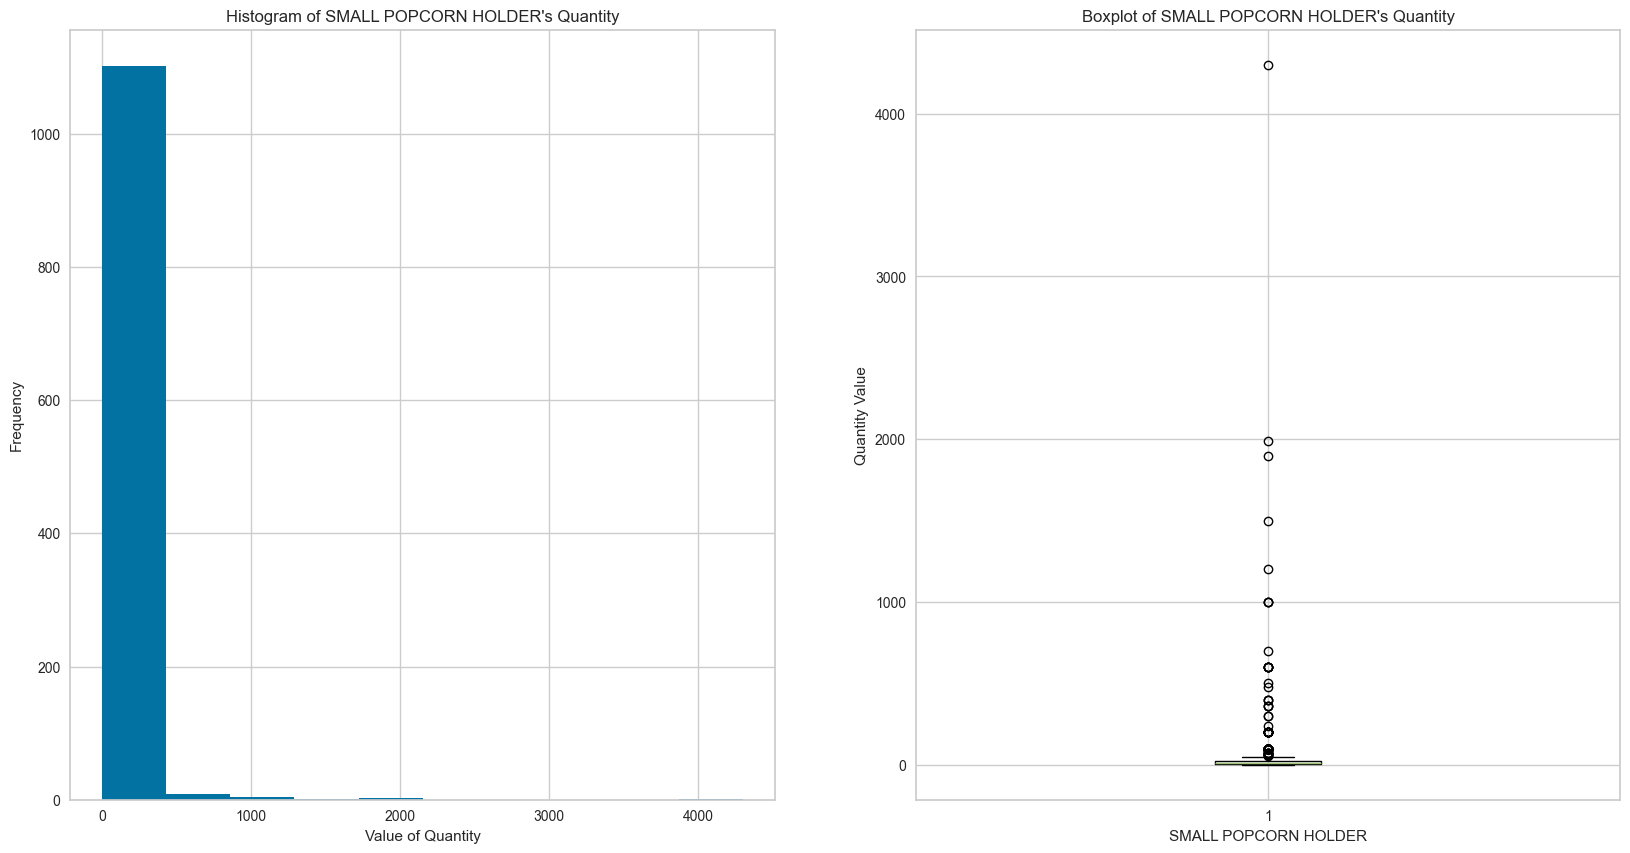

******************************************************************************************************************************************************
EMPIRE DESIGN ROSETTE:


count     26.00
mean     162.92
std      763.73
min        1.00
25%        3.00
50%       10.00
75%       10.00
max     3906.00
Name: Quantity, dtype: float64

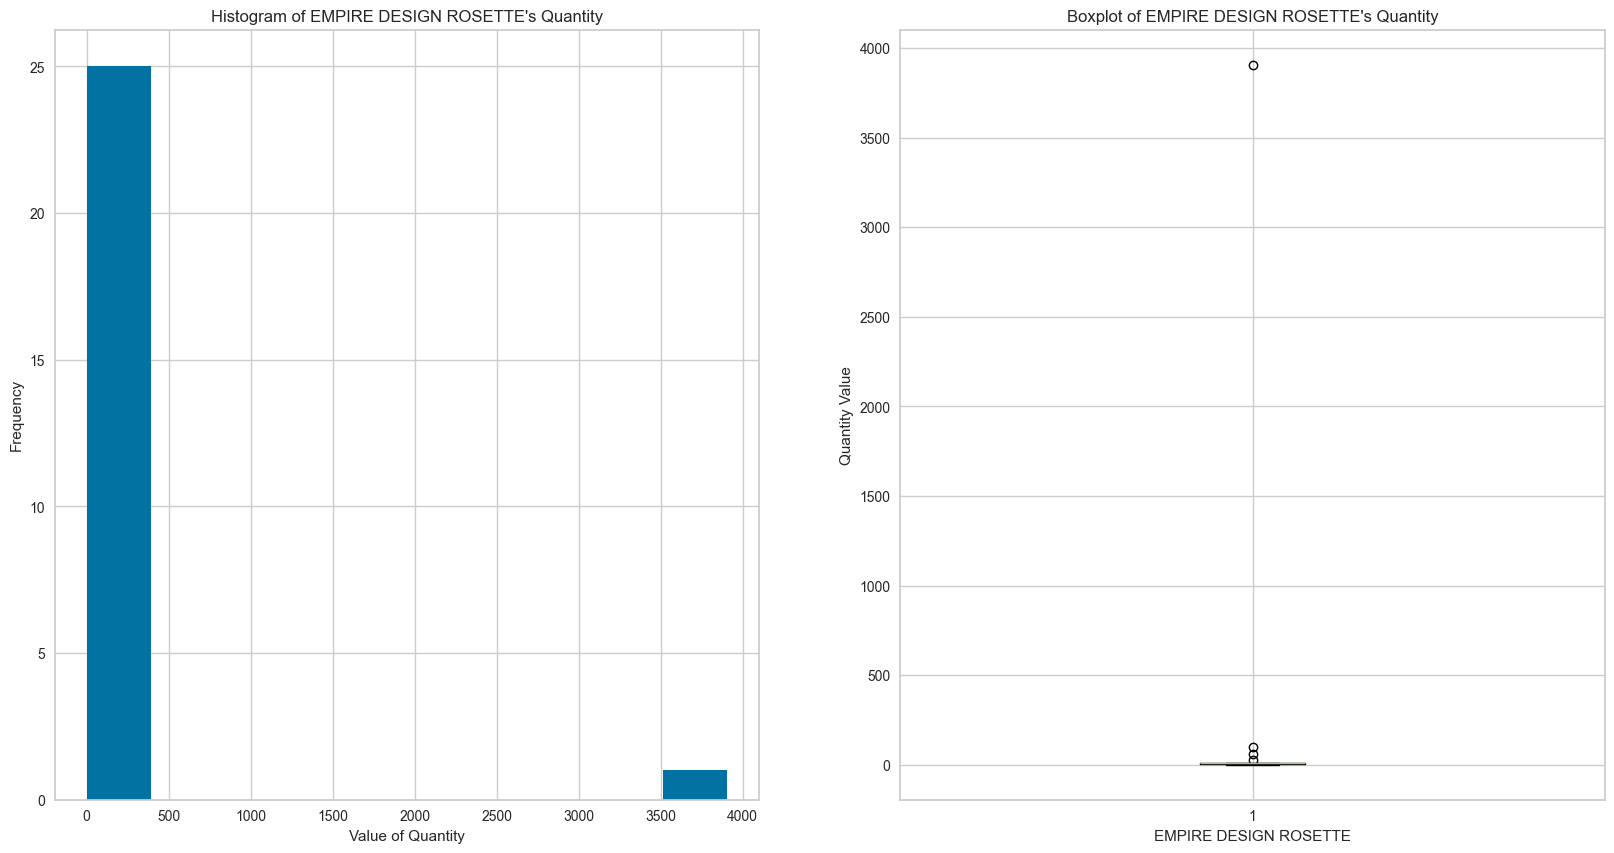

******************************************************************************************************************************************************
ESSENTIAL BALM 3.5g TIN IN ENVELOPE:


count     18.00
mean     325.33
std      907.85
min        1.00
25%       12.50
50%       24.00
75%       24.00
max     3186.00
Name: Quantity, dtype: float64

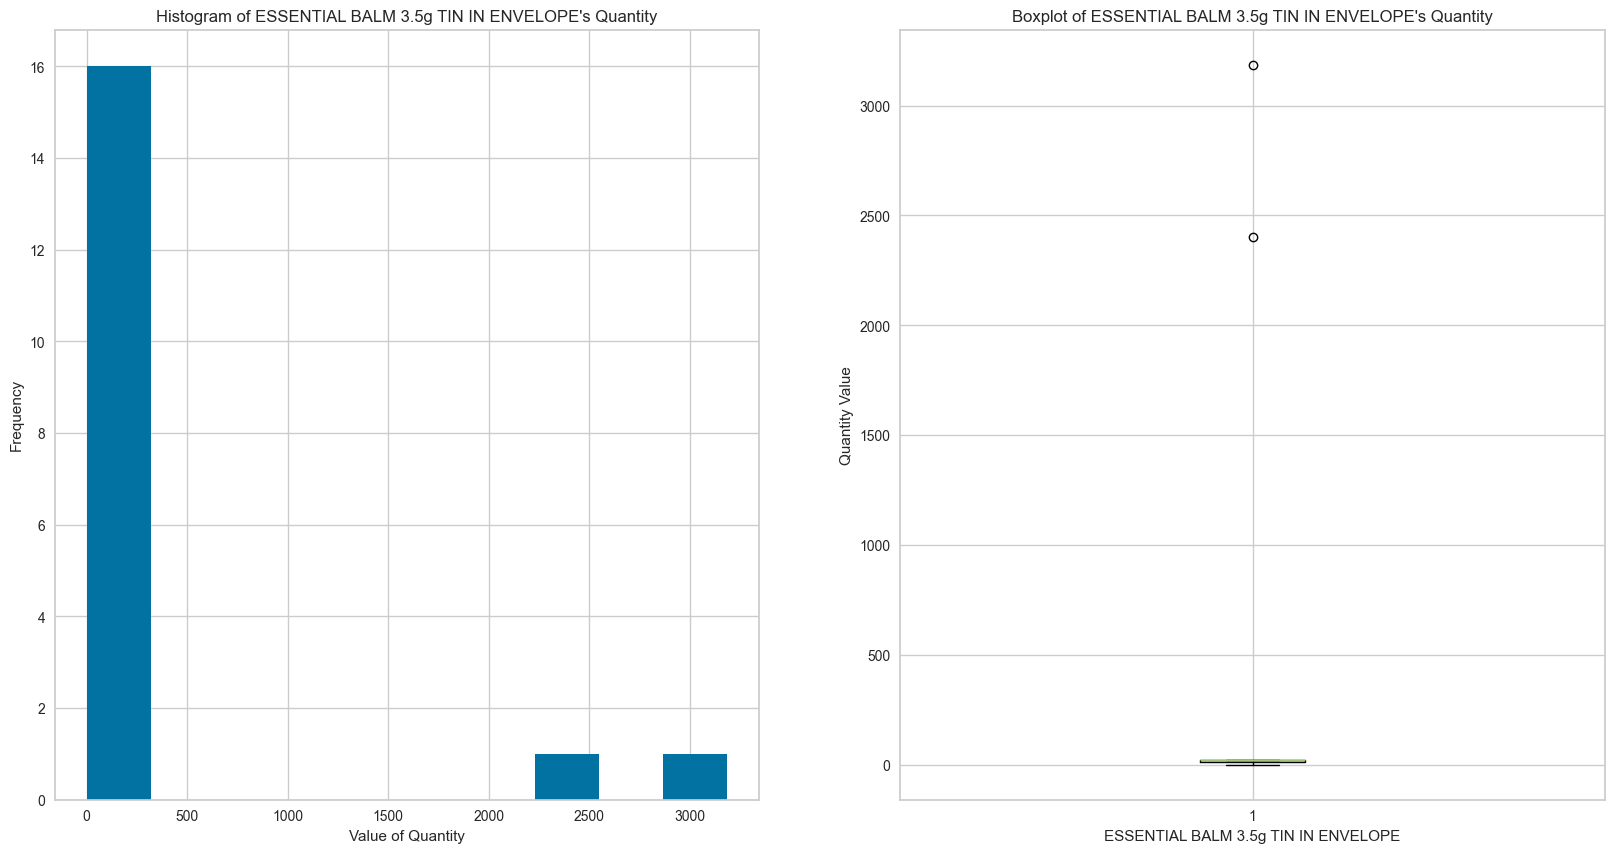

******************************************************************************************************************************************************
FAIRY CAKE FLANNEL ASSORTED COLOUR:


count    200.00
mean      66.16
std      379.24
min        1.00
25%        9.00
50%       18.00
75%       18.00
max     3114.00
Name: Quantity, dtype: float64

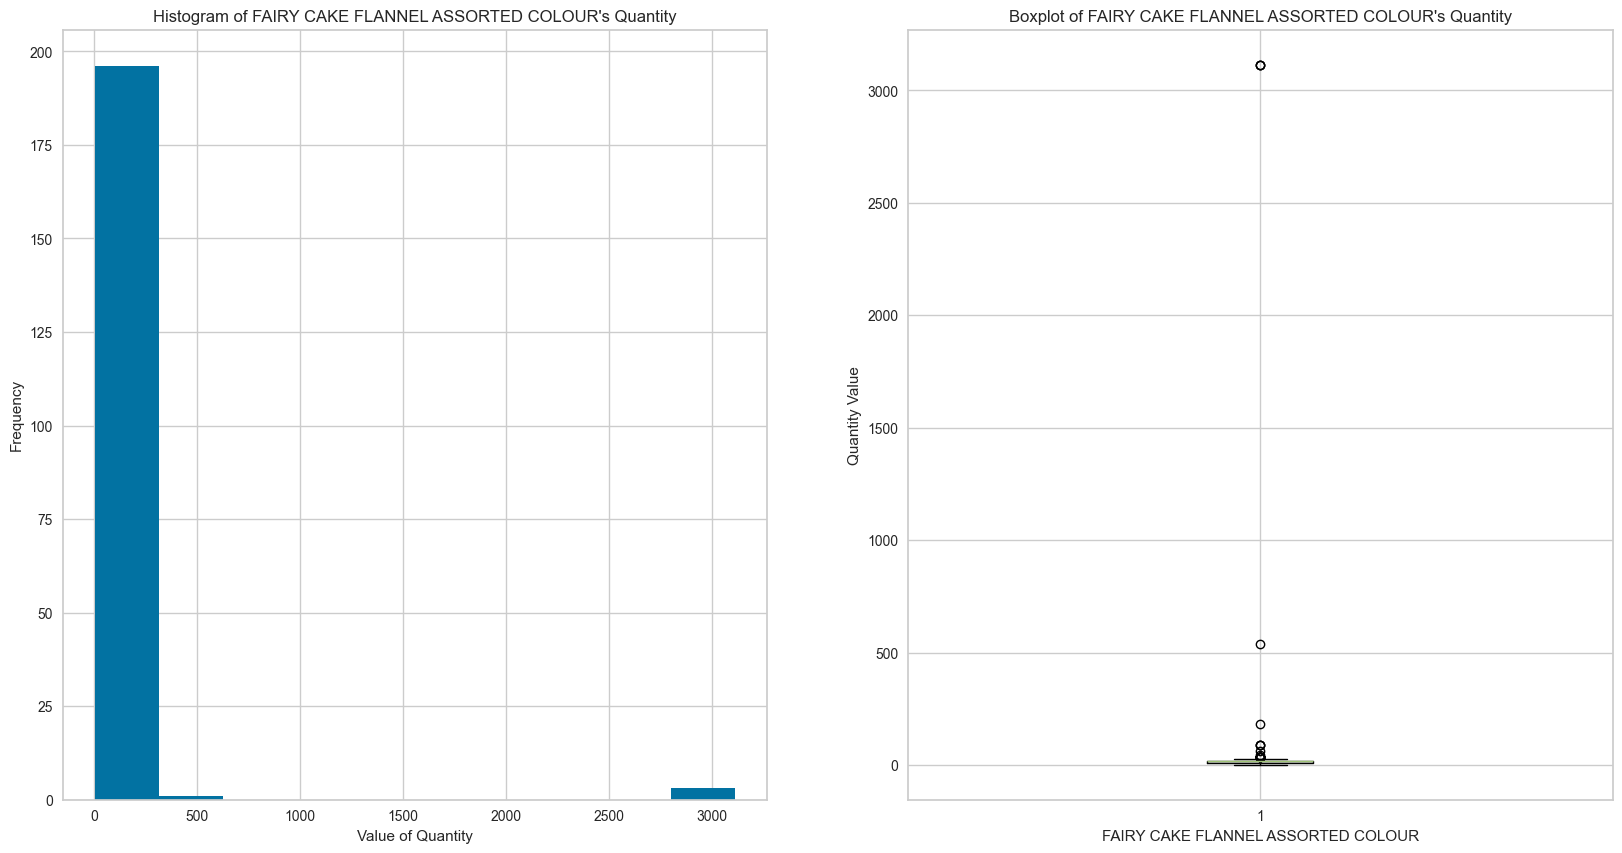

******************************************************************************************************************************************************
SMALL CHINESE STYLE SCISSOR:


count     54.00
mean     246.81
std      608.05
min        1.00
25%       10.00
50%       20.00
75%       27.50
max     3000.00
Name: Quantity, dtype: float64

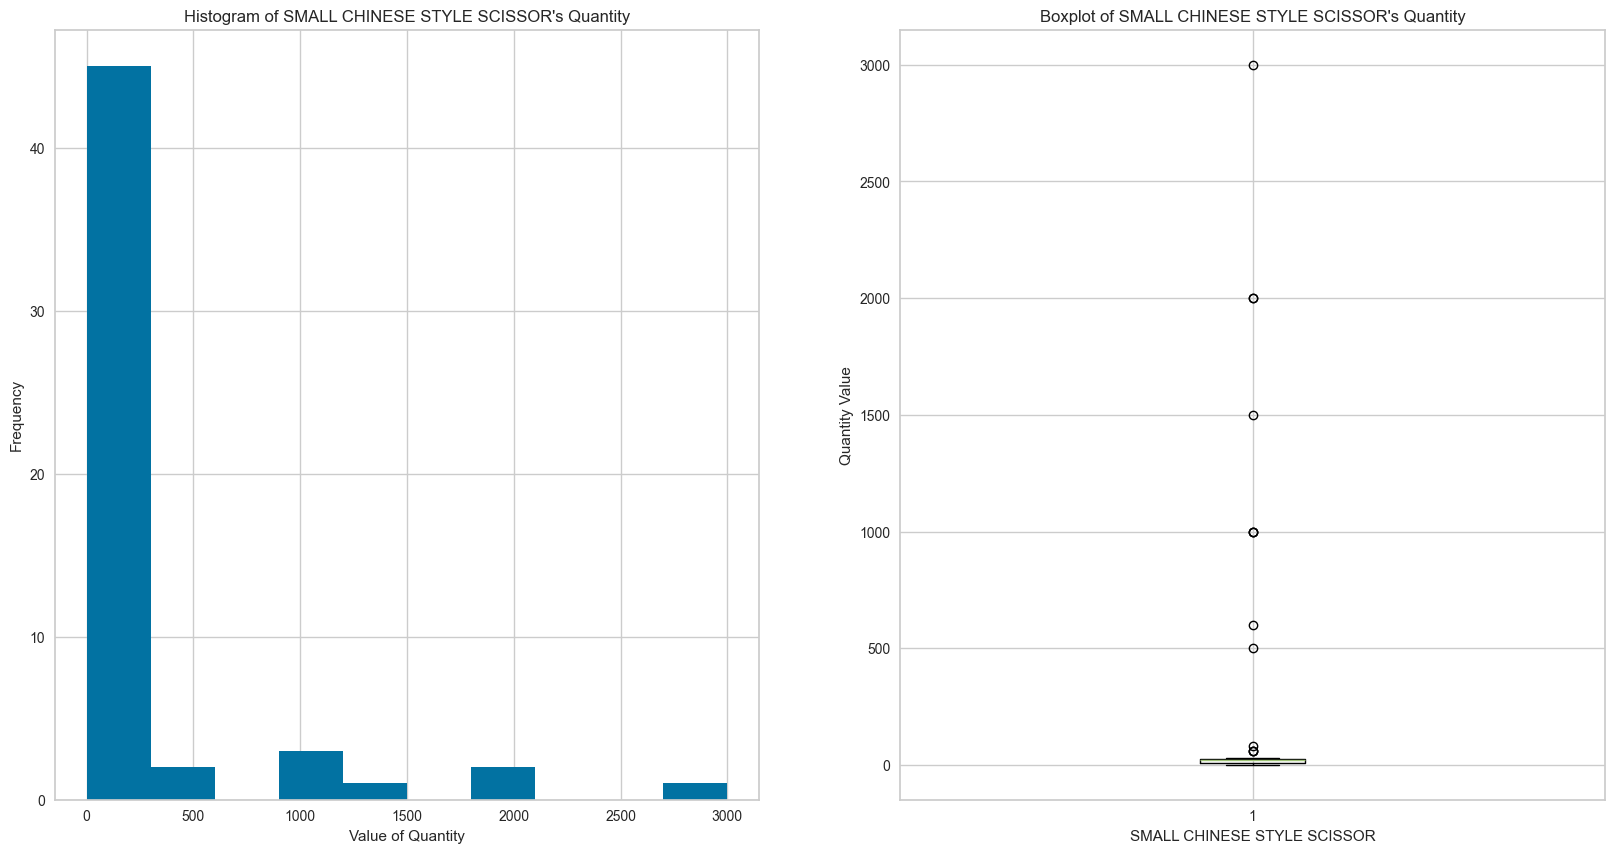

******************************************************************************************************************************************************
ASSORTED COLOUR BIRD ORNAMENT:


count   1418.00
mean      24.97
std       91.17
min        1.00
25%        8.00
50%       16.00
75%       24.00
max     2880.00
Name: Quantity, dtype: float64

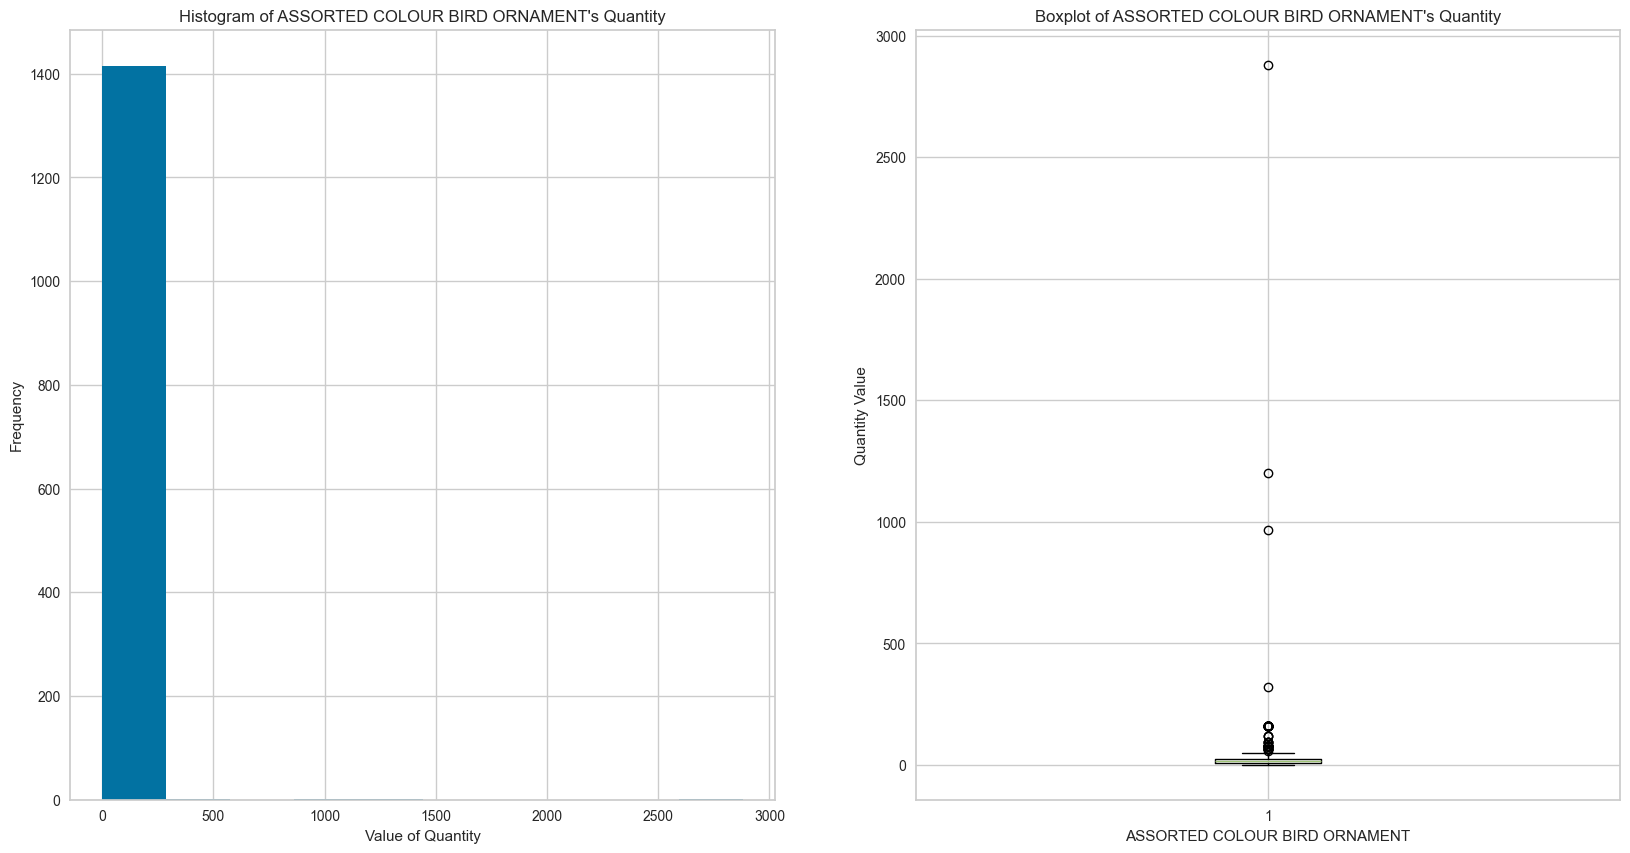

In [12]:
# Turn the the negative Quantity Values into positive
df_transactions_clean.loc[df_transactions_clean["Quantity"] < 0, "Quantity"] = \
-df_transactions_clean.loc[df_transactions_clean["Quantity"] < 0, "Quantity"]

# Check the quantity distribution of stocks with suspicious positive quantities
def stock_distribution(stock_code: str, col: str) -> None:
    """
    Prints the price summary statistics and plots histogram and boxplot
    for a specific stock
    
    Parameters
    ---------------
    stock_code: str
        Stock code of the product evaluated (Quantity or UnitPrice)
    col: str
        Column with the numerical variable whose distribution is analyzed
    
    Returns
    ---------------
    None. Prints summary statistics and plots
    
    """
    stock_name = df_transactions_clean.loc[
        df_transactions_clean["StockCode"] == stock_code, "Description" ].iloc[0]
    df_stock_subset = df_transactions_clean.loc[
        df_transactions_clean["StockCode"] == stock_code, col]
    
    print("*" * 150 + f"\n{stock_name}:")
    display(df_stock_subset.describe())

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    # Histogram
    ax1.hist(df_stock_subset)
    ax1.set_title(f"Histogram of {stock_name}'s {col}")
    ax1.set_xlabel(f"Value of {col}")
    ax1.set_ylabel("Frequency")
    #Boxplot
    ax2.boxplot(df_stock_subset, vert=True)
    ax2.set_title(f"Boxplot of {stock_name}'s {col}")
    ax2.set_xlabel(stock_name)
    ax2.set_ylabel(f"{col} Value")
    plt.show()

stock_sus_q = list(df_temp_q.iloc[0:10]["StockCode"])
for stock in stock_sus_q:
    stock_distribution(stock, "Quantity")

del stock_sus_q

In [13]:
# Remove suspicious entries Quantity
index_sus_q = df_temp_q.head(20).index
df_transactions_clean.drop(index_sus_q, inplace=True)
del df_temp_q

In [14]:
# Check abnormal UnitPrice values
# Check the observations with UnitPrice 0
print("*" * 150 + "\n Null Unit Price:")
df_temp_up_null = df_transactions_clean[df_transactions_clean["UnitPrice"] == 0]
display(df_temp_up_null)
print("Number of observations:", df_temp_up_null.shape[0])

# Check the observations with high UnitPrice
print("*" * 150 + "\n Positive Unit Price:")
df_temp_quantiles = pd.DataFrame(index=[0.75, 0.8, 0.85 , 0.9, 0.95, 0.99, 1])
df_temp_quantiles["Quantiles"] = df_temp_quantiles.index.map(lambda x: 
                                    df_transactions_clean["UnitPrice"].quantile(x))
display(df_temp_quantiles)
df_temp_up_pos = df_transactions_clean[df_transactions_clean["UnitPrice"] >
                                       df_temp_quantiles.loc[0.99, "Quantiles"]
].sort_values("UnitPrice", ascending=False)
display(df_temp_up_pos.head(50))
display(df_temp_up_pos.drop_duplicates("StockCode").head(50))

del df_temp_up_null, df_temp_quantiles, df_temp_up_pos

******************************************************************************************************************************************************
 Null Unit Price:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.00,12647,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.00,16560,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.00,14911,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.00,13081,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.00,13081,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.00,15107,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.00,17560,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.00,13239,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.00,13113,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.00,14410,United Kingdom


Number of observations: 39
******************************************************************************************************************************************************
 Positive Unit Price:


,Quantiles
0.75,3.75
0.80,4.15
0.85,4.95
0.90,6.75
0.95,8.50
0.99,15.00
1.00,38970.00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,1,2011-06-10 15:31:00,38970.00,15098,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
173277,C551685,POST,POSTAGE,1,2011-05-03 12:51:00,8142.75,16029,United Kingdom
173391,C551699,M,Manual,1,2011-05-03 14:12:00,6930.00,16029,United Kingdom
268027,C560372,M,Manual,1,2011-07-18 12:26:00,4287.63,17448,United Kingdom
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536,France
422375,C573079,M,Manual,2,2011-10-27 14:15:00,4161.06,12536,France
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore
406404,C571750,M,Manual,1,2011-10-19 11:16:00,3949.32,12744,Singapore


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,1,2011-06-10 15:31:00,38970.00,15098,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
150591,C549452,D,Discount,1,2011-04-08 14:17:00,1867.86,17940,United Kingdom
528082,580727,DOT,DOTCOM POSTAGE,1,2011-12-05 17:17:00,1599.26,14096,United Kingdom
528087,C580726,CRUK,CRUK Commission,1,2011-12-05 17:17:00,1100.44,14096,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.00,16607,United Kingdom
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.00,13452,United Kingdom
191600,553380,22826,LOVE SEAT ANTIQUE WHITE METAL,1,2011-05-16 15:29:00,195.00,17190,United Kingdom
246,536392,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2010-12-01 10:29:00,165.00,13705,United Kingdom


******************************************************************************************************************************************************
Manual:


count     465.00
mean      334.43
std      1935.07
min         0.00
25%         0.85
50%         3.00
75%       106.40
max     38970.00
Name: UnitPrice, dtype: float64

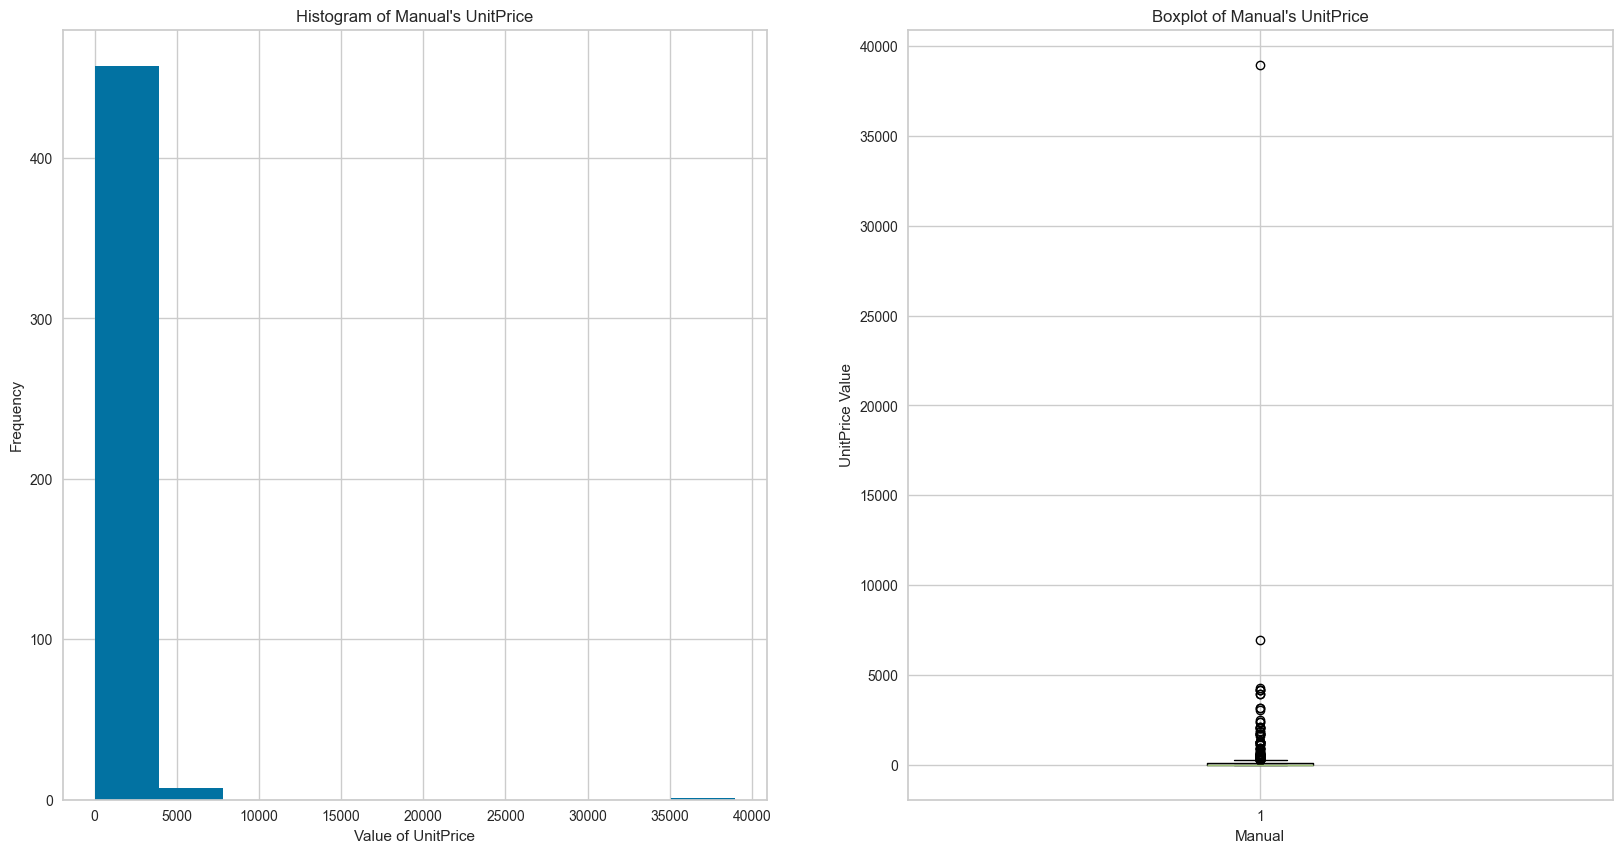

******************************************************************************************************************************************************
POSTAGE:


count   1196.00
mean      37.89
std      334.12
min        1.00
25%       18.00
50%       18.00
75%       18.00
max     8142.75
Name: UnitPrice, dtype: float64

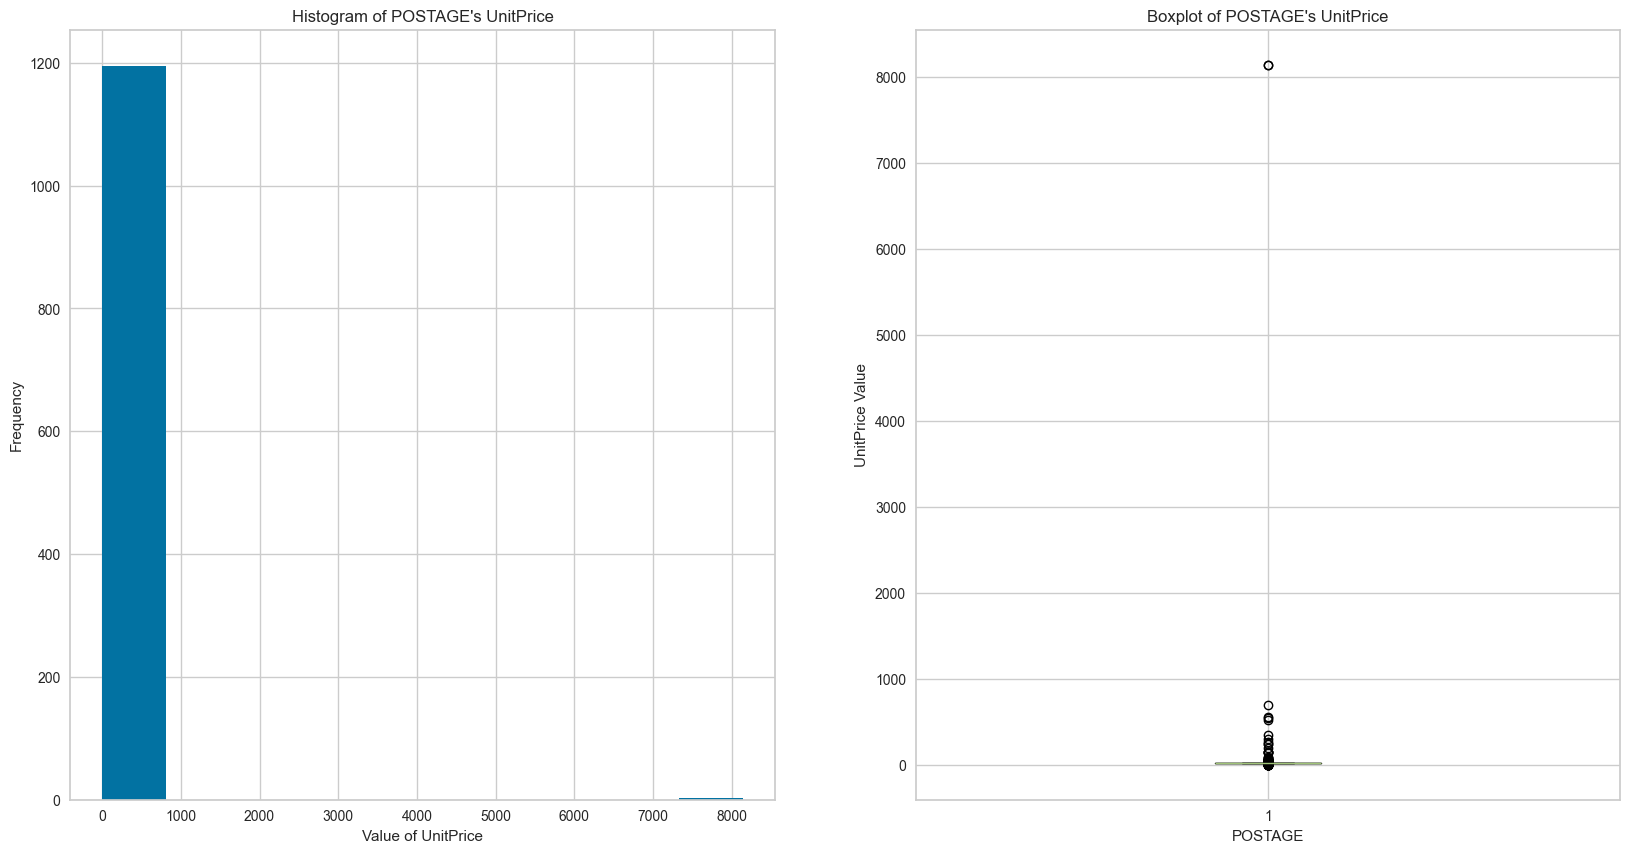

******************************************************************************************************************************************************
Discount:


count     77.00
mean      72.48
std      219.27
min        0.01
25%       13.88
50%       22.97
75%       57.60
max     1867.86
Name: UnitPrice, dtype: float64

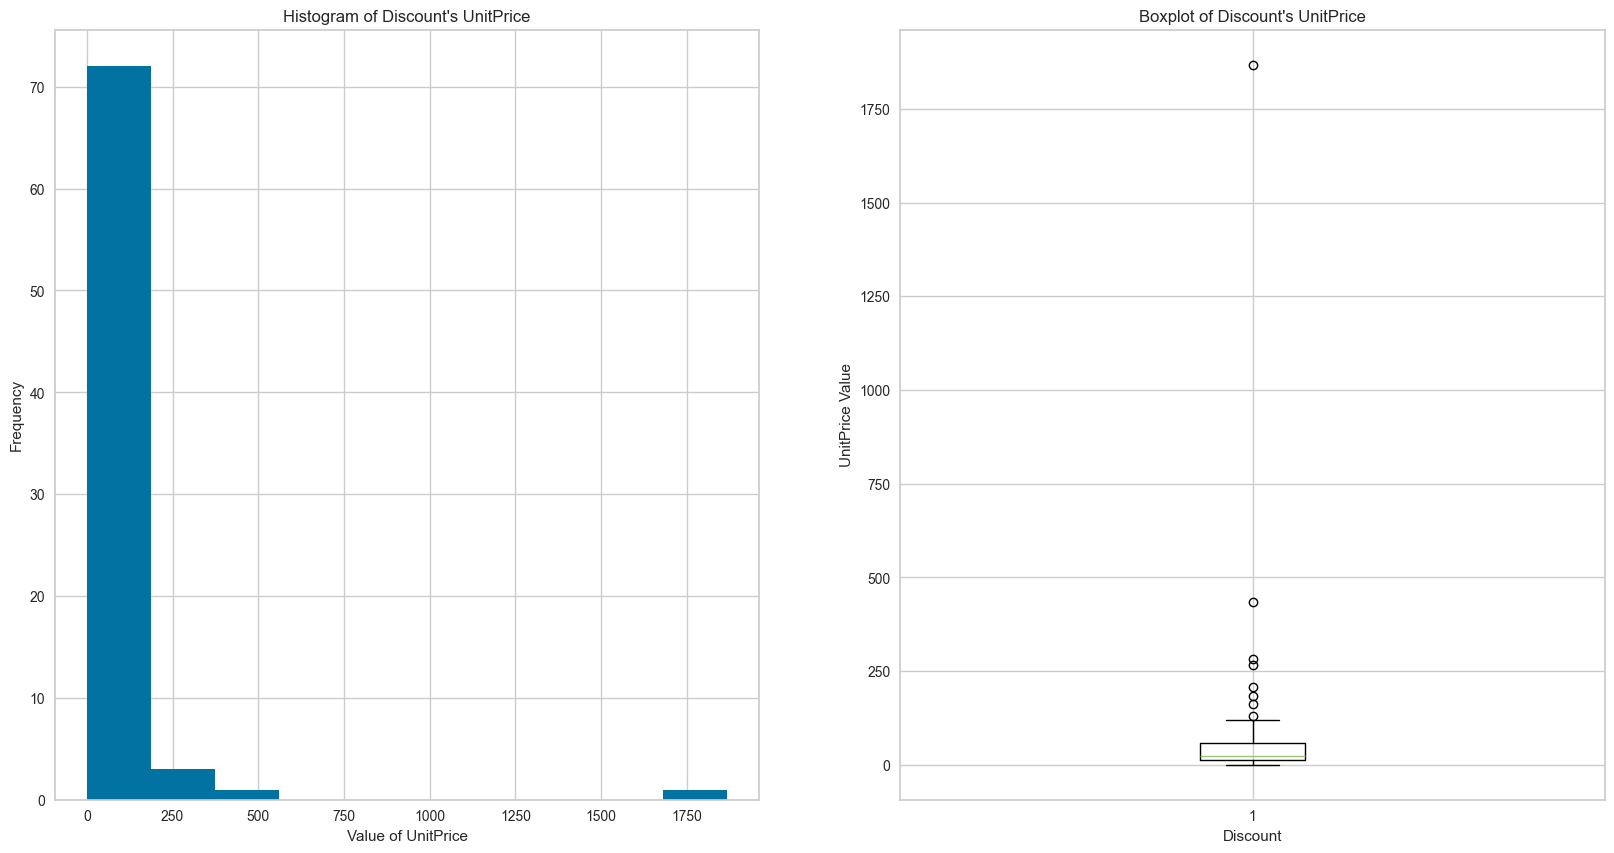

******************************************************************************************************************************************************
DOTCOM POSTAGE:


count     16.00
mean     744.15
std      540.83
min       11.17
25%      389.08
50%      715.85
75%      998.63
max     1599.26
Name: UnitPrice, dtype: float64

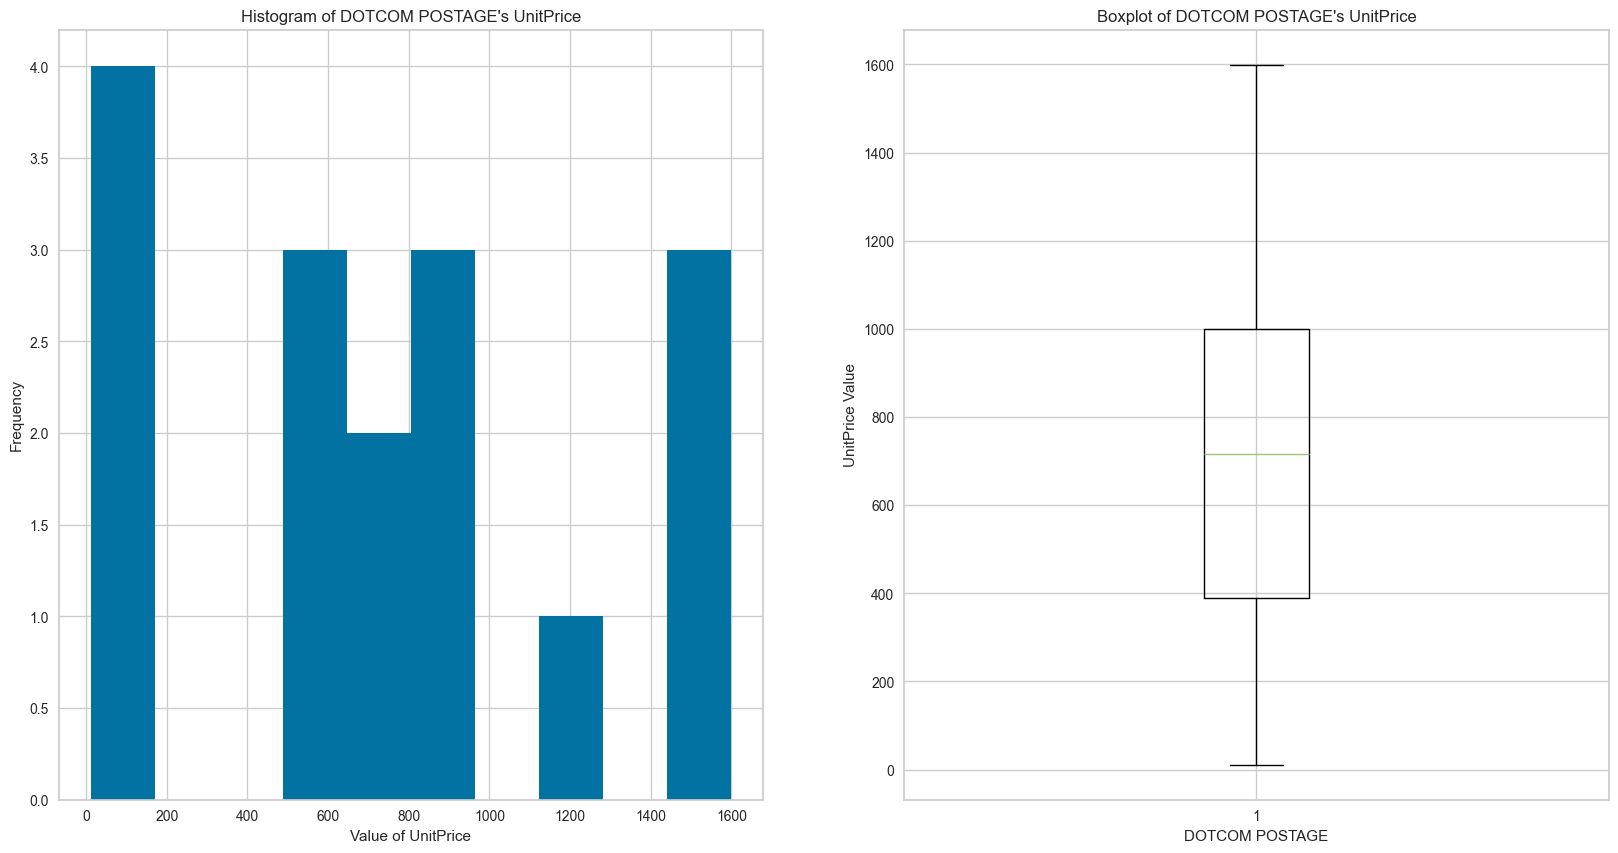

******************************************************************************************************************************************************
CRUK Commission:


count     16.00
mean     495.84
std      364.16
min        1.60
25%      284.25
50%      471.77
75%      668.98
max     1100.44
Name: UnitPrice, dtype: float64

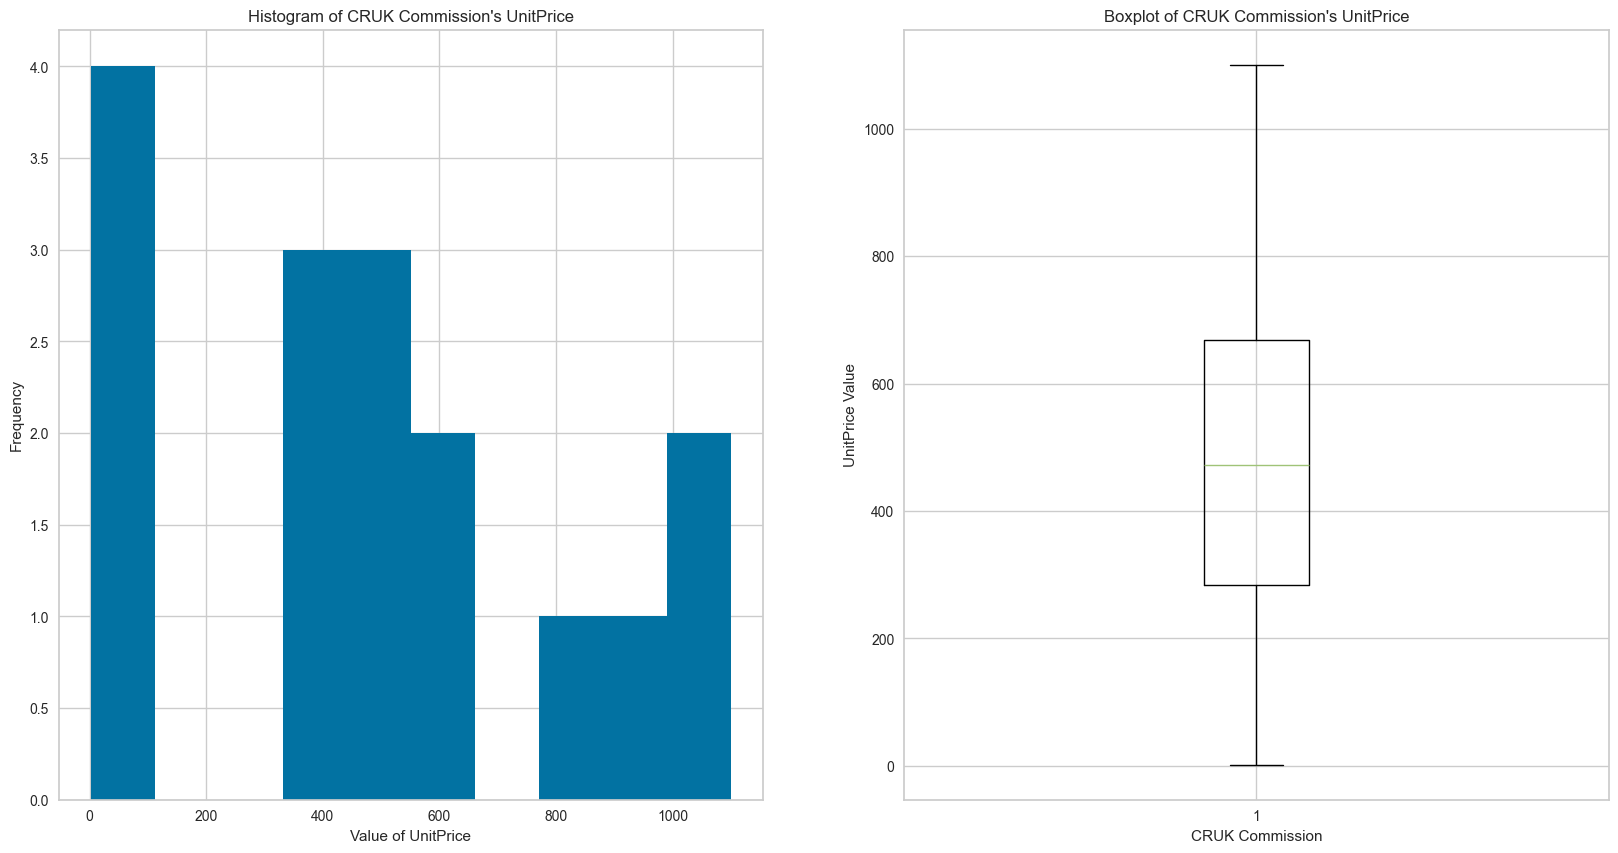

******************************************************************************************************************************************************
PICNIC BASKET WICKER SMALL:


count   248.00
mean     11.00
std      57.69
min       2.00
25%       5.95
50%       5.95
75%       5.95
max     649.50
Name: UnitPrice, dtype: float64

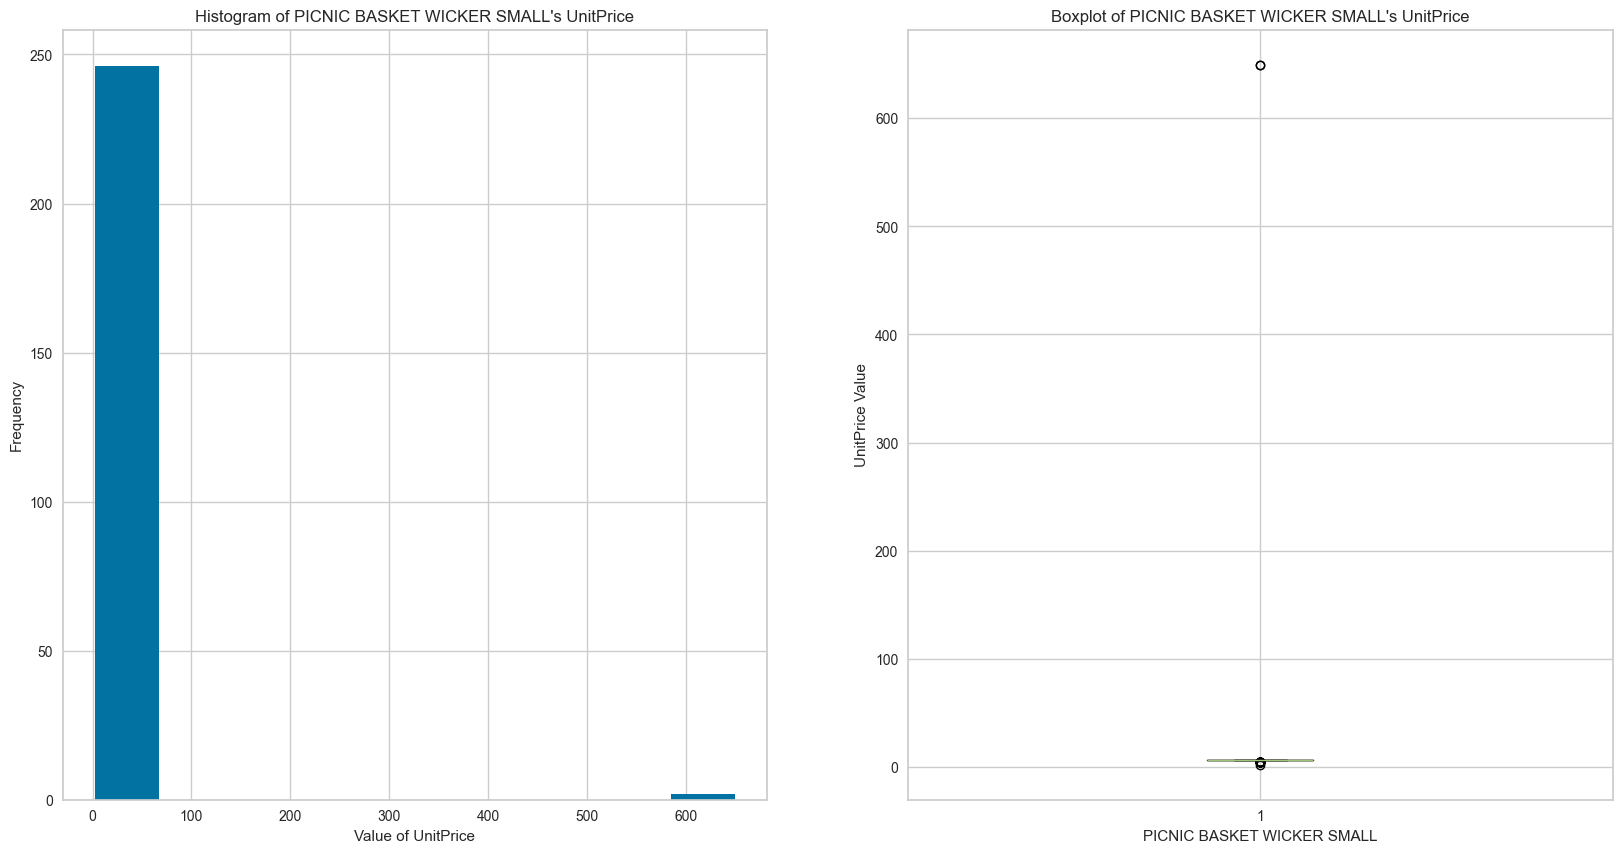

******************************************************************************************************************************************************
CARRIAGE:


count   134.00
mean     50.13
std       9.61
min      18.00
25%      50.00
50%      50.00
75%      50.00
max     150.00
Name: UnitPrice, dtype: float64

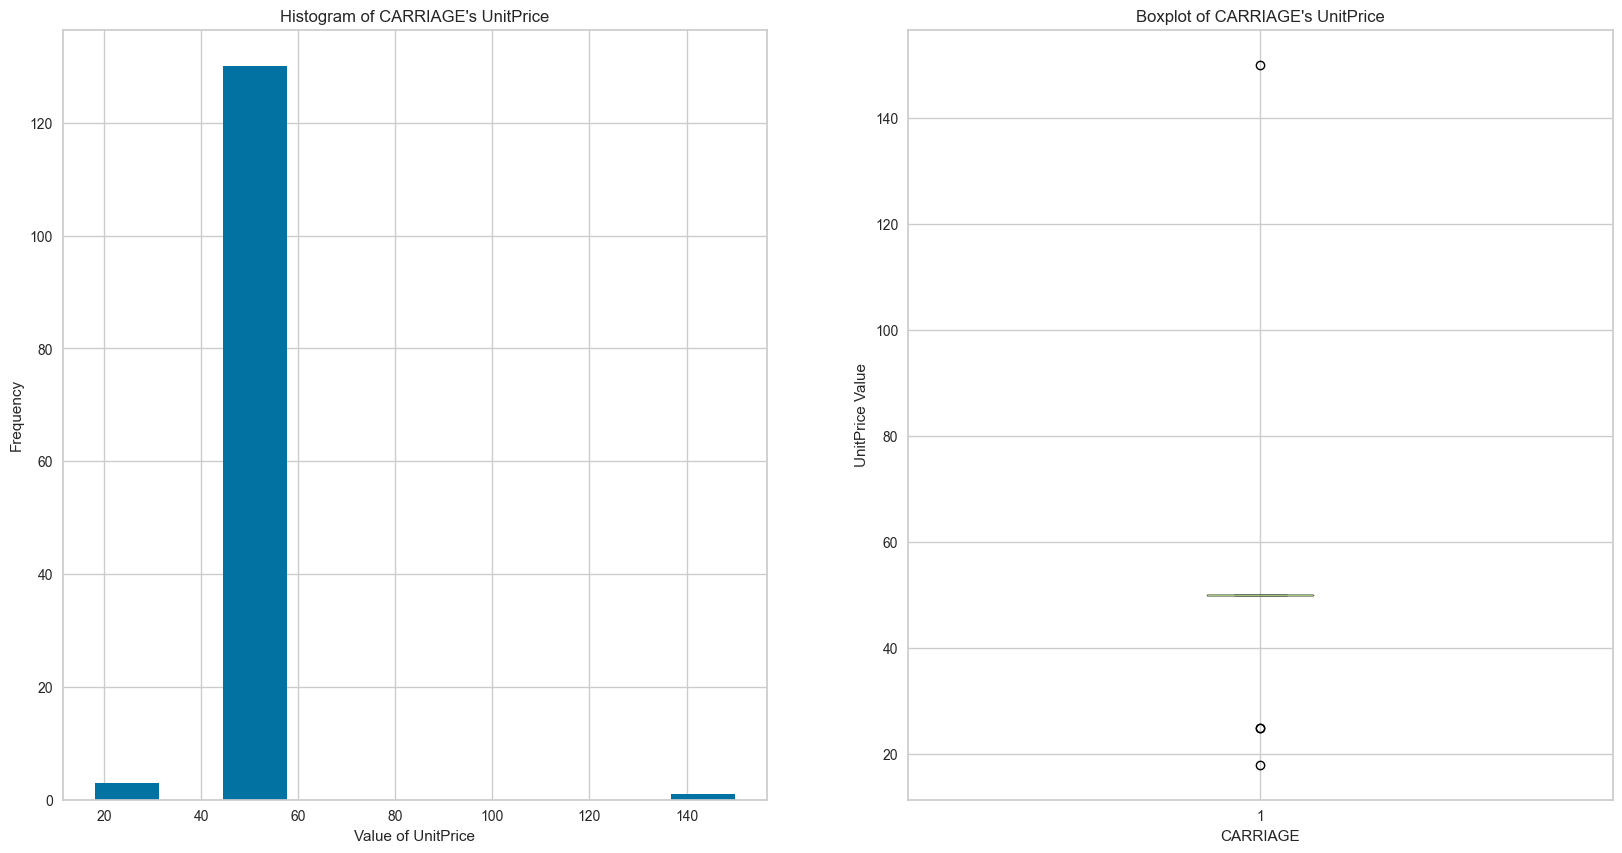

******************************************************************************************************************************************************
Bank Charges:


count   12.00
mean    13.75
std      4.33
min      0.00
25%     15.00
50%     15.00
75%     15.00
max     15.00
Name: UnitPrice, dtype: float64

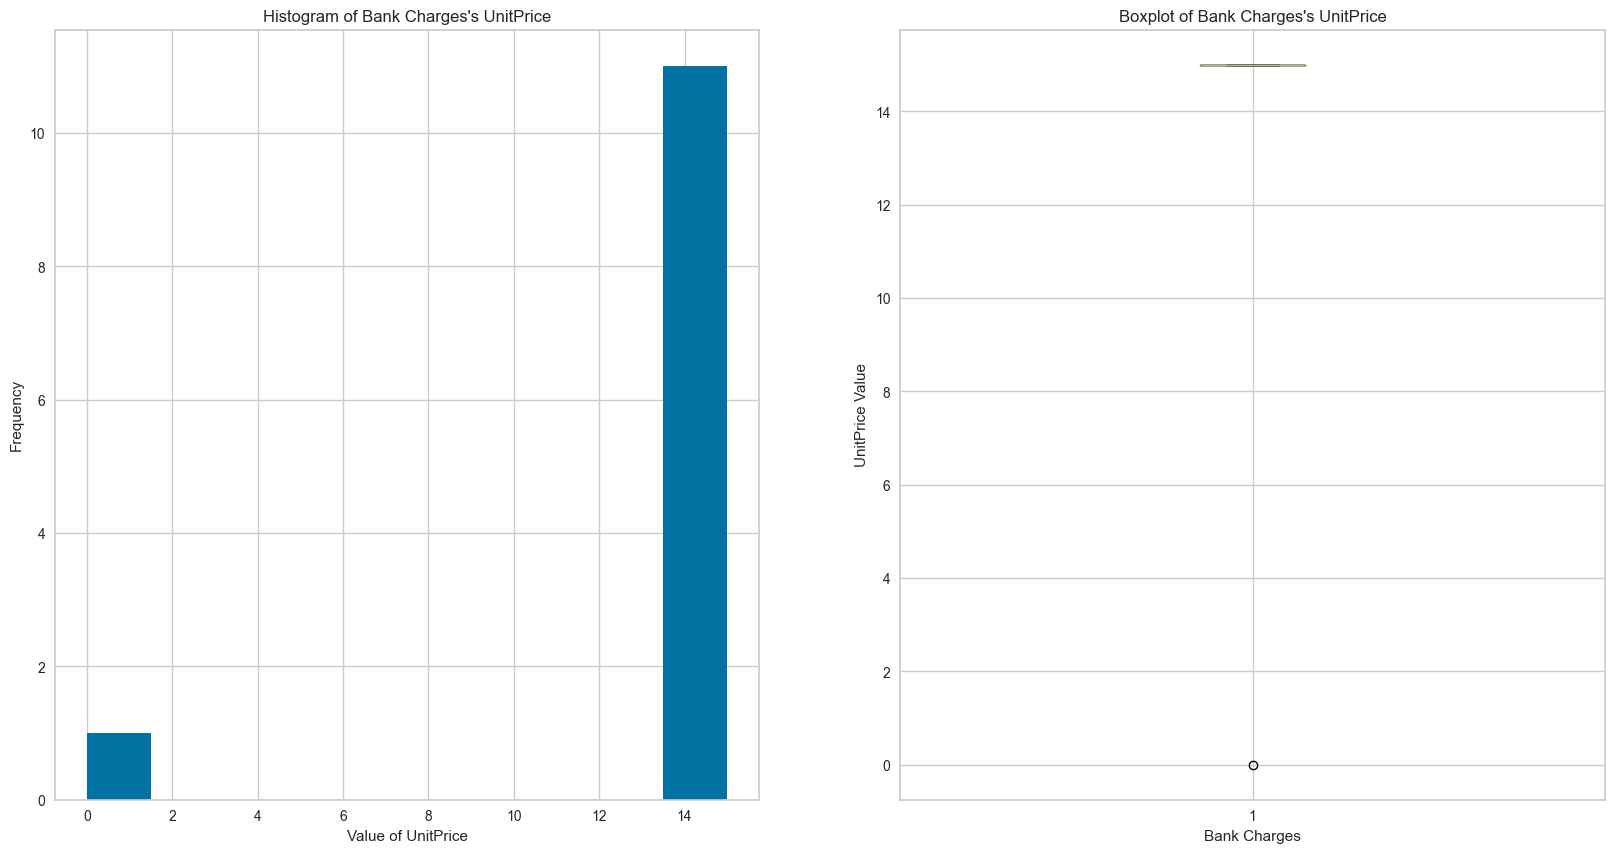

******************************************************************************************************************************************************
PADS TO MATCH ALL CUSHIONS:


count   4.00
mean    0.00
std     0.00
min     0.00
25%     0.00
50%     0.00
75%     0.00
max     0.00
Name: UnitPrice, dtype: float64

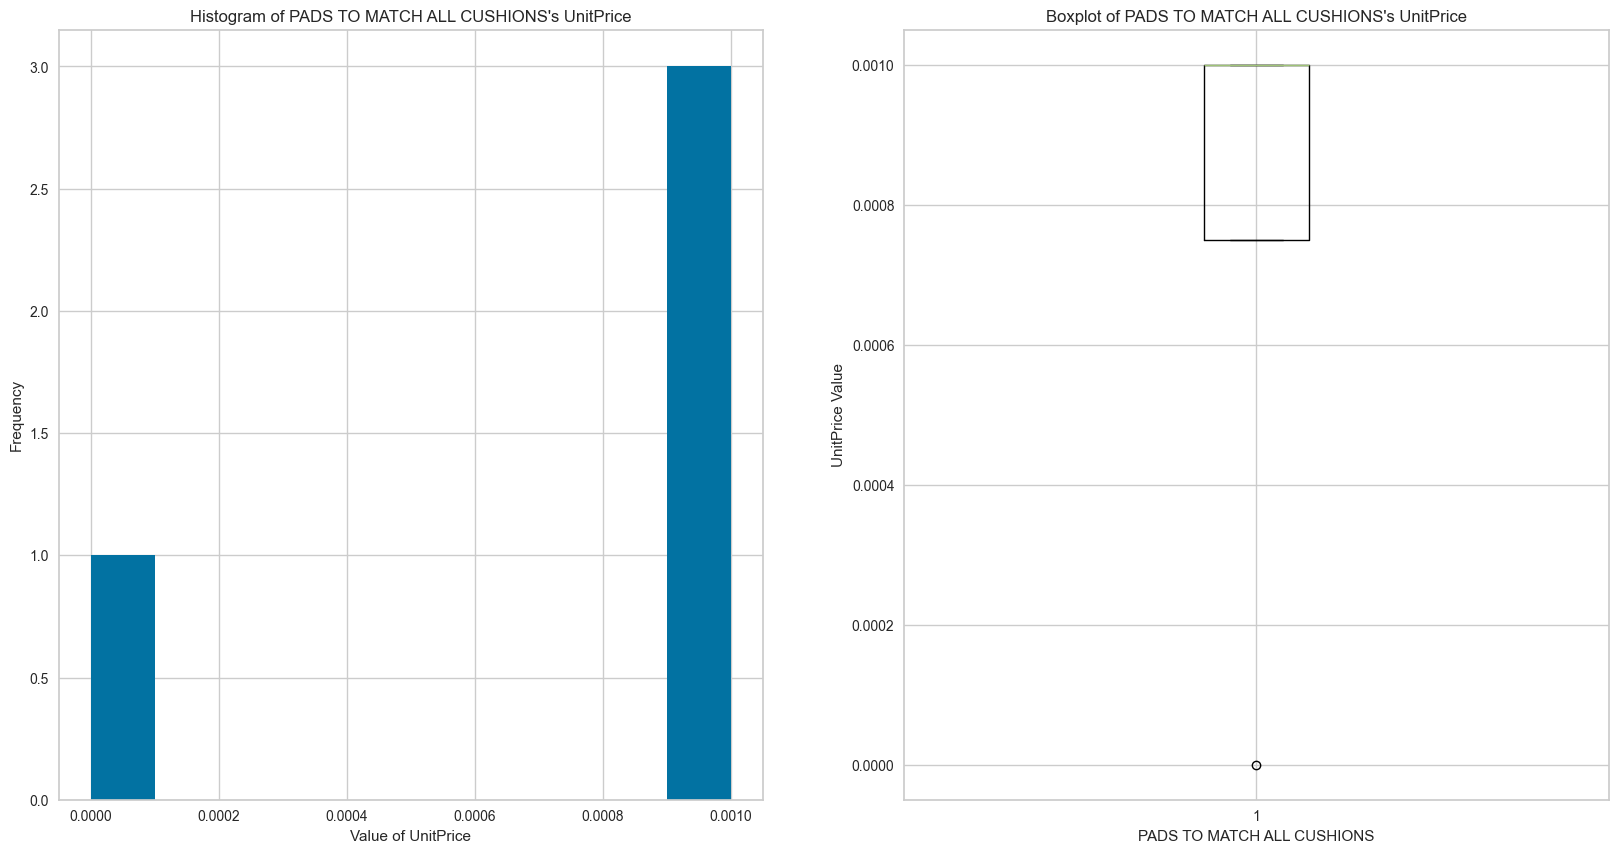

In [15]:
# Inspect the distributions of suspicious items
stock_sus_up = ["M", "POST", "D", "DOT", "CRUK", "22502", "C2", "BANK CHARGES", "PADS"]
for stock in stock_sus_up:
    stock_distribution(stock, "UnitPrice")
del stock, stock_sus_up

In [16]:
# Remove suspicious entries UnitPrice
stock_sus_del = ["M", "POST", "D", "DOT", "CRUK", "22502", "C2", "BANK CHARGES"]
df_transactions_clean = df_transactions_clean.loc[
    (df_transactions_clean["UnitPrice"] > 0) &
    (~df_transactions_clean["StockCode"].isin(stock_sus_del))
]
df_transactions_clean = df_transactions_clean.loc[
    ~((df_transactions_clean["StockCode"] == "22502") &
    (df_transactions_clean["InvoiceNo"] == "556446"))
]
df_transactions_clean.reset_index(drop=True, inplace=True)
del stock_sus_del

In [17]:
# Check if there are any entries with the same InvoiceNo and different CustomerID
df_temp_unique = df_transactions_clean.drop_duplicates(subset=["InvoiceNo", "CustomerID"])
display(df_temp_unique[df_temp_unique.duplicated(subset=["InvoiceNo"])])\

# Check if there are any entries with the same InvoiceNo and different CustomerID
df_temp_unique = df_transactions_clean.drop_duplicates(subset=["InvoiceNo", "CustomerID"])
display(df_temp_unique[df_temp_unique.duplicated(subset=["InvoiceNo"])])

# Check if there are any entries with the same InvoiceNo and different Country
df_temp_unique = df_transactions_clean.drop_duplicates(subset=["InvoiceNo", "Country"])
display(df_temp_unique[df_temp_unique.duplicated(subset=["InvoiceNo"])])

# Check if there are entries with the same InvoiceNo and different InvoiceDate
df_temp_unique = df_transactions_clean.drop_duplicates(subset=["InvoiceNo", "InvoiceDate"])
display(df_temp_unique[df_temp_unique.duplicated(subset=["InvoiceNo"], keep=False)])

# Check if there are entries with the same StockCode and different Descriptions
df_temp_unique = df_transactions_clean.drop_duplicates(subset=["StockCode", "Description"])
display(df_temp_unique[df_temp_unique.duplicated(subset=["StockCode"], keep=False)
                       ].sort_values("StockCode"))

del df_temp_unique

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1870,536591,21427,SKULLS STORAGE BOX SMALL,1,2010-12-01 16:57:00,2.10,14606,United Kingdom
1904,536591,85064,CREAM SWEETHEART LETTER RACK,2,2010-12-01 16:58:00,5.45,14606,United Kingdom
28093,540185,48194,DOORMAT HEARTS,1,2011-01-05 13:40:00,7.95,14653,United Kingdom
28112,540185,21985,PACK OF 12 HEARTS DESIGN TISSUES,24,2011-01-05 13:41:00,0.29,14653,United Kingdom
39122,541596,20971,PINK BLUE FELT CRAFT TRINKET BOX,4,2011-01-19 16:18:00,1.25,17602,United Kingdom
...,...,...,...,...,...,...,...,...
300389,571735,22675,FRENCH KITCHEN SIGN BLUE METAL,12,2011-10-19 10:04:00,1.25,14229,United Kingdom
346937,576057,21977,PACK OF 60 PINK PAISLEY CAKE CASES,6,2011-11-13 15:05:00,0.55,15861,United Kingdom
346963,576057,22384,LUNCH BAG PINK POLKADOT,3,2011-11-13 15:06:00,1.65,15861,United Kingdom
374480,578548,23322,LARGE WHITE HEART OF WICKER,2,2011-11-24 15:02:00,2.95,17345,United Kingdom


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
93759,548189,16156L,WRAP CAROUSEL,25,2011-03-29 15:15:00,0.42,16607,United Kingdom
29929,540404,16156L,"WRAP, CAROUSEL",25,2011-01-07 09:40:00,0.42,12947,United Kingdom
228959,564734,17107D,FLOWER FAIRY 5 DRAWER LINERS,4,2011-08-28 13:32:00,2.55,12484,Spain
4356,536945,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS",3,2010-12-03 12:24:00,2.55,14083,United Kingdom
252594,567338,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS,6,2011-09-19 15:00:00,2.55,14146,United Kingdom
...,...,...,...,...,...,...,...,...
24276,539456,90014A,SILVER/MOP ORBIT NECKLACE,1,2010-12-17 17:23:00,9.95,16885,United Kingdom
18355,538638,90014B,GOLD M PEARL ORBIT NECKLACE,1,2010-12-13 14:16:00,9.95,17231,United Kingdom
284699,570241,90014B,GOLD M.O.P. ORBIT NECKLACE,1,2011-10-09 15:24:00,2.95,14801,United Kingdom
378774,578993,90014C,SILVER AND BLACK ORBIT NECKLACE,1,2011-11-27 15:38:00,2.95,15987,United Kingdom


In [18]:
# Compute the value counts of categorical variables
df_temp_descriptions = df_transactions_clean[[
    "StockCode", "Description"]].drop_duplicates().set_index("StockCode")

# For each Product, number of entries and the quantity sold
print("*" * 150 + "\nStockCode and Total Quantity distribution:")
display(df_transactions_clean["StockCode"
].value_counts().to_frame().join(df_temp_descriptions, how="left"))

df_temp_total_q = df_transactions_clean	[[
    "StockCode", "Quantity"]
].groupby("StockCode").sum().sort_values("Quantity", ascending=False
).join(df_temp_descriptions, how="left")
display(df_temp_total_q)
display(df_temp_total_q.describe())

# Country
df_temp_unique = df_transactions_clean.drop_duplicates("CustomerID")
print("*" * 150 + "\nCountry, in raw data set and by unique customer:")
display(
    df_transactions_clean.value_counts("Country").to_frame().join(
    df_transactions_clean.value_counts("Country", normalize=True).to_frame(),
    how="left"
))
display(
    df_temp_unique.value_counts("Country").to_frame().join(
    df_temp_unique.value_counts("Country", normalize=True), how="left"  
))
del df_temp_total_q, df_temp_descriptions, df_temp_unique

******************************************************************************************************************************************************
StockCode and Total Quantity distribution:


,count,Description
StockCode,,
85123A,2076,WHITE HANGING HEART T-LIGHT HOLDER
85123A,2076,CREAM HANGING HEART T-LIGHT HOLDER
22423,1904,REGENCY CAKESTAND 3 TIER
85099B,1662,JUMBO BAG RED RETROSPOT
84879,1417,ASSORTED COLOUR BIRD ORNAMENT
...,...,...
79323W,1,WHITE CHERRY LIGHTS
37379A,1,PINK CHERRY BLOSSOM CUP & SAUCER
90035C,1,"PEARL & SHELL 42""NECKL. IVORY"


,Quantity,Description
StockCode,,
23843,80995,"PAPER CRAFT , LITTLE BIRDIE"
23166,78195,MEDIUM CERAMIC TOP STORAGE JAR
84077,50815,WORLD WAR 2 GLIDERS ASSTD DESIGNS
85099B,47296,JUMBO BAG RED RETROSPOT
22197,45354,SMALL POPCORN HOLDER
...,...,...
85126,1,LARGE ROUND CUTGLASS CANDLESTICK
85098B,1,BLUE FLYING SINGING CANARY
84227,1,HEN HOUSE W CHICK IN NEST


,Quantity
count,3907.00
mean,1484.80
std,3611.35
min,1.00
25%,72.00
50%,438.00
75%,1509.50
max,80995.00


******************************************************************************************************************************************************
Country, in raw data set and by unique customer:


,count,proportion
Country,,
United Kingdom,360984,0.89
Germany,9093,0.02
France,8166,0.02
EIRE,7373,0.02
Spain,2467,0.01
Netherlands,2325,0.01
Belgium,1971,0.00
Switzerland,1843,0.00
Portugal,1436,0.00


,count,proportion
Country,,
United Kingdom,3938,0.90
Germany,95,0.02
France,87,0.02
Spain,28,0.01
Belgium,24,0.01
Switzerland,20,0.00
Portugal,19,0.00
Italy,14,0.00
Finland,12,0.00


******************************************************************************************************************************************************
UnitPrice:


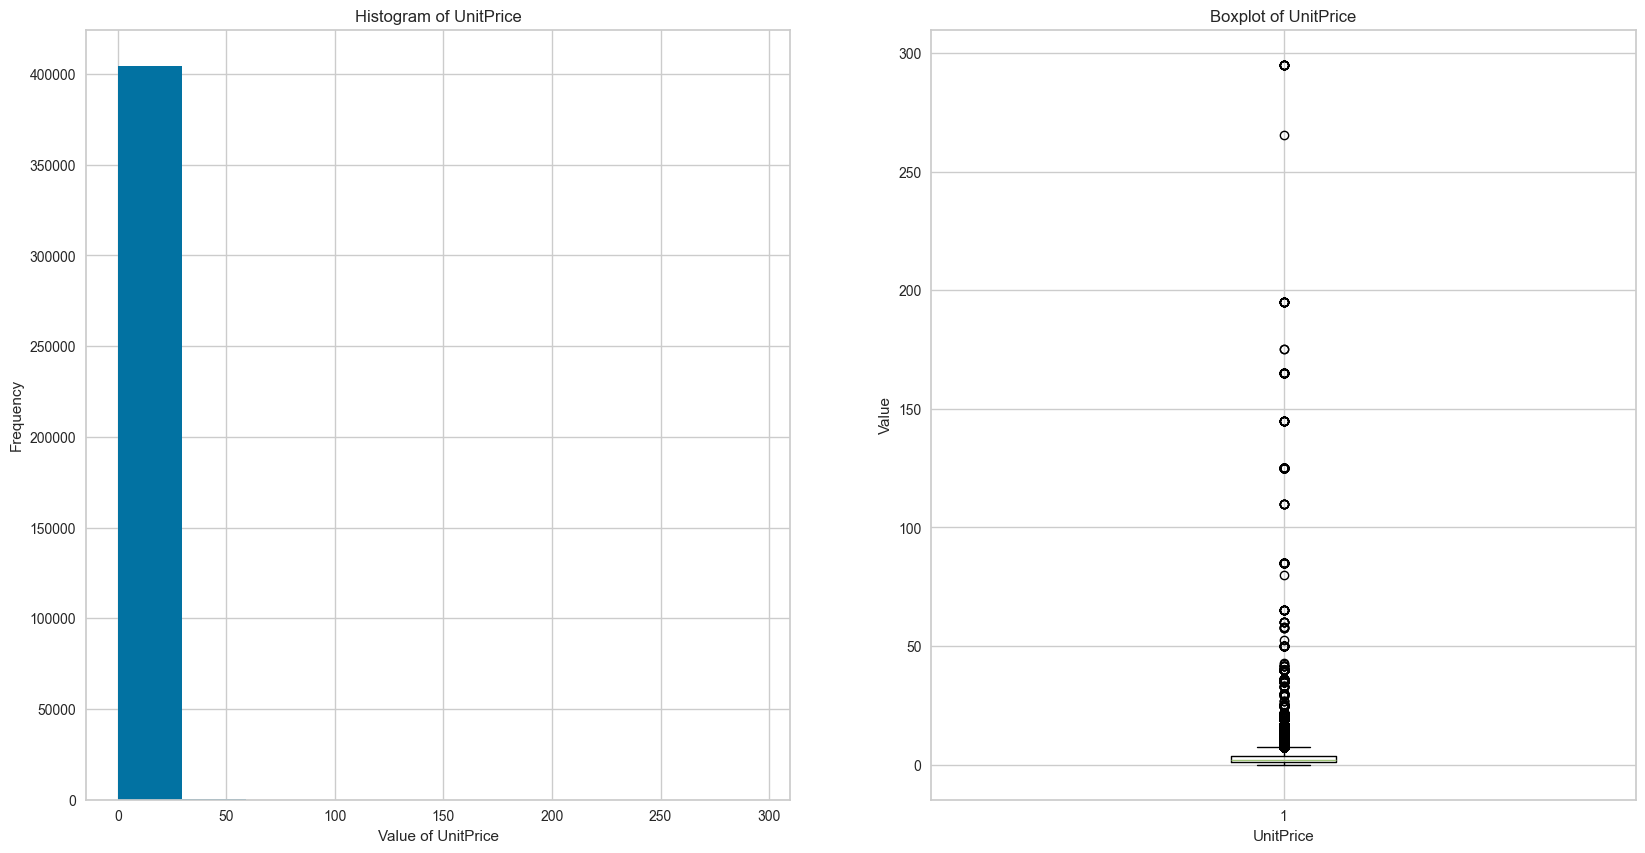

Number of Outliers: 34469
Percentage of Outliers 8.52%
Skewness: 22.675658294052866
Kurtosis: 1069.5038616073844
Shapiro: 0.4105096443498434 | p_value: 5.238912198244886e-201 

******************************************************************************************************************************************************
Quantity:


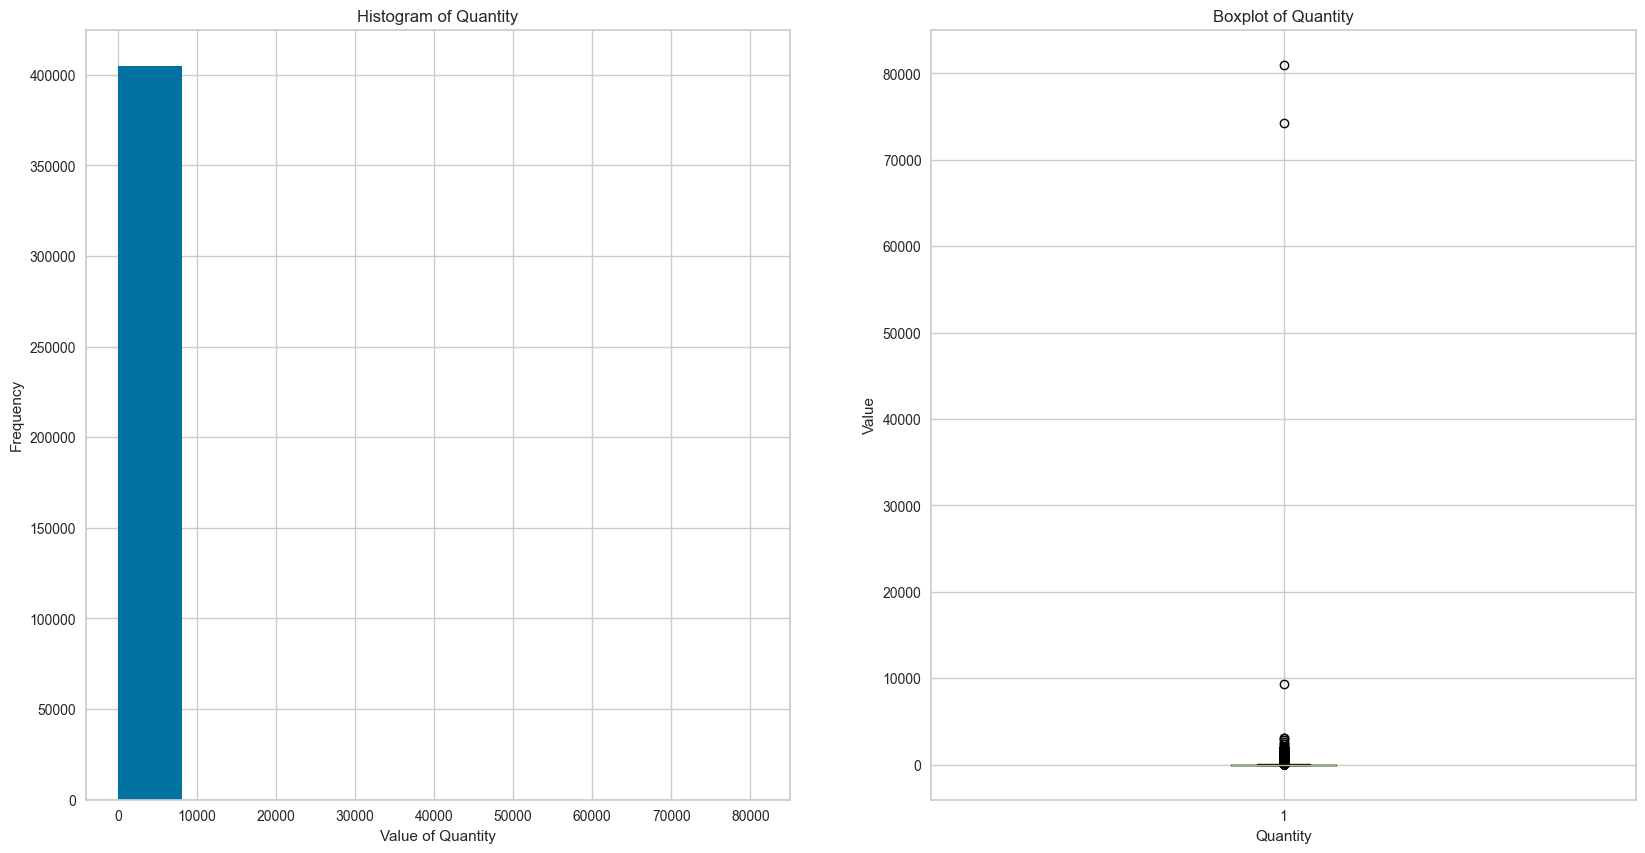

Number of Outliers: 26106
Percentage of Outliers 6.45%
Skewness: 414.37526785362274
Kurtosis: 181710.00818501724
Shapiro: 0.012638090955001235 | p_value: 1.0658091315404516e-220 



In [19]:
def distribution(df_col : pd.Series, plot_distribution : bool = True) -> list:
       """
    Computes distribution statisitcs of 'df_col'
    
    Parameters
    ---------------
    df_col: pd.Series
        Pandas series used to compute the distribution statistics
    plot_distribution: bool
        Boolean value with default value True, that determines whether
        an histogram and boxplot are plotted and if the calculated stats
        are printed
 
    Returns
    ---------------
    l_dist_stats: list
        A list with the distribution statistics. First position [0] has
        number of outliers, second position [1] the percentage of 
        outliers, third position [2] the skewness, forth [3] the 
        kurtosis and fith [4] and sixth [5] the outcomes of the 
        Shapiro-Wilk test (W-stat and p-value)
    
    """
       # Number of outliers computed using 1.5 IQR range
       q1 = df_col.quantile(0.25)
       q3 = df_col.quantile(0.75)
       iqr = q3 - q1
       n_outliers = df_col[
              (df_col < (q1 - 1.5 * iqr)) | ((df_col > (q3 + 1.5 * iqr)))
       ].shape[0]
       per_outliers = n_outliers / df_col.shape[0]

       # Skewness, Kurtosis and Shapiro-Wilk test computed using 
       # scipy.stats library (ignoring nans)
       skewness = skew(df_col, nan_policy="omit")
       kurt = kurtosis(df_col, nan_policy="omit")
       shapiro_stat, p_value = shapiro(df_col.dropna())

       if plot_distribution:
              df_plot = df_col.dropna()
              fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

              # Histogram
              ax1.hist(df_plot)
              ax1.set_title(f"Histogram of {df_plot.name}")
              ax1.set_xlabel(f"Value of {df_plot.name}")
              ax1.set_ylabel(f"Frequency")

              #Boxplot
              ax2.boxplot(df_plot, vert=True)
              ax2.set_title(f"Boxplot of {df_plot.name}")
              ax2.set_xlabel(df_plot.name)
              ax2.set_ylabel(f"Value")
              
              plt.show()

              # Print stats
              print("Number of Outliers:", n_outliers)
              print("Percentage of Outliers", 
                    str(round(100 * per_outliers, 2)) + "%")
              print("Skewness:", skewness)
              print("Kurtosis:", kurt)
              print("Shapiro:", shapiro_stat, "| p_value:", p_value, "\n")
              return None
       
       l_dist_stats = [
              n_outliers, per_outliers, skewness, kurt, shapiro_stat, p_value
       ]
       return l_dist_stats

temp_cols = ["UnitPrice", "Quantity"]

for col in temp_cols:
       print("*" * 150 + f"\n{col}:")
       distribution(df_transactions_clean[col])

del temp_cols

---
##### 3. Uniqueness
- There are 10070 duplicates (2.49%) in the dataset. Duplicates were evaluated as repeat combinations of InvoiceNo, CustomerID and StockCode. Sometimes, the same invoice will have multiple entries for the same product, but the price is changed. In others, the entries have the same price, but a slightly different InvoiceDate.
- In this case, will just aggregate the entries that have the same Unit price, and leave the rest as it is.

In [20]:
# Look for repeat entries based on the StockCode, InvoiceNo and CustomerID
def number_of_duplicates(df: pd.DataFrame, print_output: bool = True) -> int:
    """
       Computes number of duplicates of 'df', based on unique identifier 
       variable (StockCode, InvoiceNo and CustomerID)   
    Parameters
    ---------------
    df: pd.DataFrame
        Pandas series used to compute the distribution statistics
    print_output: bool
        Boolean value with default value True, that determines whether
        the number of duplicates will be printed in text output,
        in addition to an example of duplicate rows
 
    Returns
    ---------------
    n_duplicates: int
        Int value with the number of duplicate rows of 'df', based on
        the columns StockCode, InvoiceNo and CustomerID
    
    """
       
    n_duplicates = df.duplicated(subset=["StockCode", "InvoiceNo", "CustomerID"]).sum()
    p_duplicates = round(100 * n_duplicates / df.shape[0], 2)

    if print_output:
        var_name = [name for name, value in globals().items() if value is df][0]
        print("*" * 150, "\n" + var_name + ":")
        print("Number of Duplicates:", n_duplicates)
        print("Percentage of Duplicates:", str(p_duplicates) + "%")

    return n_duplicates, p_duplicates

n_uniqueness_old, p_uniqueness_old = number_of_duplicates(df_transactions_clean)

****************************************************************************************************************************************************** 
df_transactions_clean:
Number of Duplicates: 10070
Percentage of Duplicates: 2.49%


In [21]:
# Check if there are different prices in the duplicate products
df_temp_unique = df_transactions_clean.drop_duplicates(subset=["InvoiceNo", "StockCode", "UnitPrice"])
display(df_temp_unique[df_temp_unique.duplicated(subset=["InvoiceNo", "StockCode"], keep=False)].head(100))
del df_temp_unique

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7879,537236,22073,RED RETROSPOT STORAGE JAR,16,2010-12-06 09:52:00,3.39,16858,United Kingdom
7885,537236,22073,RED RETROSPOT STORAGE JAR,8,2010-12-06 09:52:00,3.75,16858,United Kingdom
10550,537624,72800E,4 IVORY DINNER CANDLES SILVER FLOCK,12,2010-12-07 14:41:00,2.10,12748,United Kingdom
10604,537624,72800E,4 IVORY DINNER CANDLES SILVER FLOCK,2,2010-12-07 14:41:00,2.55,12748,United Kingdom
22122,539102,21181,PLEASE ONE PERSON METAL SIGN,144,2010-12-16 10:37:00,1.53,16029,United Kingdom
...,...,...,...,...,...,...,...,...
297189,571441,23263,SET OF 3 WOODEN HEART DECORATIONS,2,2011-10-17 13:31:00,2.50,14096,United Kingdom
317115,573325,84968A,SET OF 16 VINTAGE ROSE CUTLERY,4,2011-10-30 10:58:00,12.75,15370,United Kingdom
317116,573325,84968A,SET OF 16 VINTAGE ROSE CUTLERY,24,2011-10-30 10:58:00,10.95,15370,United Kingdom
321337,573576,23263,SET OF 3 WOODEN HEART DECORATIONS,7,2011-10-31 14:09:00,2.46,14096,United Kingdom


In [22]:
# Display duplicates found
display(df_transactions_clean[df_transactions_clean.duplicated(subset=[
    "StockCode", "InvoiceNo", "CustomerID"], keep=False)
].sort_values(["InvoiceNo", "StockCode", "Description"]).head(50))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
112,536381,71270,PHOTO CLIP LINE,1,2010-12-01 09:41:00,1.25,15311,United Kingdom
124,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311,United Kingdom
489,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
512,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908,United Kingdom
480,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
534,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
484,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
522,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908,United Kingdom
516,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom
532,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908,United Kingdom


In [23]:
# Aggregate entries where the product, invoice and stock are the same
df_transactions_clean = df_transactions_clean.groupby([
    "InvoiceNo", "StockCode", "UnitPrice", "CustomerID", "Country"
]).agg({"Quantity":"sum", "Description":"first", "InvoiceDate":"first"}
).reset_index()

---
##### 4. Timeliness:
- The transactions span from the beguinning of December 2010 until next year December 2011, so relatively recent and relevant data.

In [24]:
# Based on the date time variables, check if the data refers to old transactions
df_timestamps = df_transactions_clean.drop_duplicates("InvoiceNo")[["InvoiceDate"]]
df_timestamps = df_timestamps.apply(lambda x: x.view('int64'))
quantiles = df_timestamps.quantile([0, 0.1, 0.25, 0.5, 0.75, 1])
quantile_dates = quantiles.apply(lambda x: pd.to_datetime(x))
display(quantile_dates)
display(df_transactions_clean["InvoiceDate"].describe())

del df_timestamps, quantiles, quantile_dates

,InvoiceDate
0.00,2010-12-01 08:26:00
0.10,2011-01-13 16:31:00
0.25,2011-03-28 14:42:30
0.50,2011-07-08 09:03:00
0.75,2011-10-10 17:11:30
1.00,2011-12-09 12:50:00


count                           394611
mean     2011-07-10 06:39:45.477545984
min                2010-12-01 08:26:00
25%                2011-04-06 14:53:00
50%                2011-07-29 11:56:00
75%                2011-10-19 16:16:00
max                2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

---
#### Data Quality Metrics:
Taking into account the cleaning done, the two metrics we can use to assess data quality is the count and percentage of rows with NaNs, and the percentage of Duplicates. We can observe that all NaNs were cleaned and that the percentage of duplicates reduced from 2.49% to 0.02%.

In [25]:
# Completeness
_, _, _, n_completeness_new, p_completeness_new = nan_stats(df_transactions_clean)
print("Change in NaNs:", n_completeness_old - n_completeness_new)
print("Old Percentage:", p_completeness_old, "\nNew Percentage:", p_completeness_new)

del p_completeness_old, p_completeness_new, n_completeness_old, n_completeness_new


****************************************************************************************************************************************************** 
NaNs in df_transactions_clean:


InvoiceNo      0
StockCode      0
UnitPrice      0
CustomerID     0
Country        0
Quantity       0
Description    0
InvoiceDate    0
dtype: int64

Total Rows with NaNs: 0
Percentage of Rows with NaNs 0.0%
Total NaNs: 0
Percentage of NaNs 0.0%
Change in NaNs: 136534
Old Percentage: 3.15 
New Percentage: 0.0


In [26]:
# Uniqueness
n_uniqueness_new, p_uniqueness_new = number_of_duplicates(df_transactions_clean)
print("Old Percentage:", p_uniqueness_old, "New Percentage", p_uniqueness_new)

del n_uniqueness_old, p_uniqueness_old, n_uniqueness_new, p_uniqueness_new

****************************************************************************************************************************************************** 
df_transactions_clean:
Number of Duplicates: 69
Percentage of Duplicates: 0.02%
Old Percentage: 2.49 New Percentage 0.02


---
#### Creating Additional Features
Before doing further EDA, we will create the following features, that considering the business context, can help us to segment customers in the clustering task and create a recommendation system.

In the original data:
- Calculate the total amount spent on the product and on the order
- Do a rolling count of the number of orders
- Compute a categorical variable for the season (in the shopping sense, so for e.g. December and January are in the same season to not split the Christmas season) and the time of the day

In a new dataframe where each row aggregates customer information:
- Country
- Total Number of Orders
- Average Price of the Orders
- Average Quantity of Items
- Most common Season and Time of day
- Average Time Between Orders

In [27]:
# Computing new features
df_features = df_transactions_clean.copy()

# Rolling Number of orders by customer
df_features.sort_values("InvoiceDate", inplace=True)
df_features["CustomerOrdersCum"] = df_features.drop_duplicates(["CustomerID", 
                                        "InvoiceNo"]).groupby(["CustomerID"]).cumcount() + 1
df_features["CustomerOrdersCum"].fillna(method="ffill", inplace=True)

# Total Amount Spent on the product and on the order
df_features["ProductPrice"] = np.multiply(df_features["UnitPrice"],
                                          df_features["Quantity"])
df_temp = df_features.groupby(["InvoiceNo"])[["ProductPrice"]].sum().rename(
                                                    columns={"ProductPrice":"OrderPrice"})
df_features = df_features.merge(df_temp, how="left", left_on="InvoiceNo", right_index=True)

# Number of items in the order
df_temp = df_features.groupby(["InvoiceNo"])[["Quantity"]].sum().rename(
                                                    columns={"Quantity":"OrderQuantity"})
df_features = df_features.merge(df_temp, how="left", left_on="InvoiceNo", right_index=True)

# Time of Day and Season
def get_time_season(date) -> str:
    """
       Get the season from a datetime object, as a categorical variable.
    Parameters
    ---------------
    date:
        datetime object
    Returns
    ---------------
    season: str
        Possible values are Winter, Spring, Summer and Autumn.
    """
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    if month in [3, 4, 5]:
        return "Spring"
    if month in [6, 7, 8]:
        return "Summer"
    if month in [9, 10, 11]:
        return "Autumn"
def get_time_day(date) -> str:
    """
       Get the time of the day from a datetime object, as a categorical 
       variable.
    Parameters
    ---------------
    date:
        datetime object
    Returns
    ---------------
    season: str
        Possible values are Morning, Afternoon and Night.
    """
    hour = date.hour
    if 6 <= hour <= 11:
        return "Morning"
    elif 12 <= hour <= 19:
        return "Afternoon"
    else:
        return "Night"
    
df_features["Season"] = df_features["InvoiceDate"].apply(get_time_season)
df_features["TimeDay"] = df_features["InvoiceDate"].apply(get_time_day)

del df_temp
display(df_features)

,InvoiceNo,StockCode,UnitPrice,CustomerID,Country,Quantity,Description,InvoiceDate,CustomerOrdersCum,ProductPrice,OrderPrice,OrderQuantity,Season,TimeDay
0,536365,21730,4.25,17850,United Kingdom,6,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00,1.00,25.50,139.12,40,Winter,Morning
1,536365,22752,7.65,17850,United Kingdom,2,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00,1.00,15.30,139.12,40,Winter,Morning
2,536365,71053,3.39,17850,United Kingdom,6,WHITE METAL LANTERN,2010-12-01 08:26:00,1.00,20.34,139.12,40,Winter,Morning
3,536365,84029E,3.39,17850,United Kingdom,6,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,1.00,20.34,139.12,40,Winter,Morning
4,536365,84029G,3.39,17850,United Kingdom,6,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,1.00,20.34,139.12,40,Winter,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386140,581587,23254,4.15,12680,France,4,CHILDRENS CUTLERY DOLLY GIRL,2011-12-09 12:50:00,4.00,16.60,249.45,105,Winter,Afternoon
386141,581587,23255,4.15,12680,France,4,CHILDRENS CUTLERY CIRCUS PARADE,2011-12-09 12:50:00,4.00,16.60,249.45,105,Winter,Afternoon
386142,581587,23256,4.15,12680,France,4,CHILDRENS CUTLERY SPACEBOY,2011-12-09 12:50:00,4.00,16.60,249.45,105,Winter,Afternoon
386134,581587,22631,1.95,12680,France,12,CIRCUS PARADE LUNCH BOX,2011-12-09 12:50:00,4.00,23.40,249.45,105,Winter,Afternoon


In [28]:
# Define a seperate dataframe where each row represents a customer
df_customer = pd.DataFrame()
df_customer["CustomerID"] = df_features["CustomerID"].unique()
# Country
df_temp = df_features.groupby("CustomerID")[["Country"]].agg(lambda x: x.mode()[0])
df_customer = df_customer.merge(df_features[["CustomerID", "Country"]],
                                left_on="CustomerID",
                                right_on="CustomerID").drop_duplicates("CustomerID")
# Total Number of Orders
df_temp = df_features.drop_duplicates("InvoiceNo").groupby("CustomerID")[
["InvoiceNo"]].count().rename(columns={"InvoiceNo":"CustomerOrdersTotal"})
df_customer = df_customer.merge(df_temp, how="left", left_on="CustomerID", 
                                right_index=True).drop_duplicates("CustomerID")

# Average Order Price
df_temp = df_features.drop_duplicates("InvoiceNo").groupby("CustomerID")[["OrderPrice"]].mean()
df_customer = df_customer.merge(df_temp, how="left", left_on="CustomerID", 
                                right_index=True)

# Average Order Quantity
df_temp = df_features.drop_duplicates("InvoiceNo").groupby("CustomerID")[["OrderQuantity"]].mean()
df_customer = df_customer.merge(df_temp, how="left", left_on="CustomerID", 
                                right_index=True)

# Average Unit Price
df_customer["UnitPrice"] = df_customer["CustomerOrdersTotal"] / df_customer["OrderQuantity"]

# Most Frequent Season and Time of Day
df_temp = df_features.groupby("CustomerID")[["Season"]].agg(lambda x: x.mode()[0])
df_customer = df_customer.merge(df_temp, how="left", left_on="CustomerID", 
                                right_index=True)

df_temp = df_features.groupby("CustomerID")[["TimeDay"]].agg(lambda x: x.mode()[0])
df_customer = df_customer.merge(df_temp, how="left", left_on="CustomerID", 
                                right_index=True)

# Average Time Between Orders
df_temp = df_features[["CustomerID", "InvoiceDate"]].sort_values("InvoiceDate")
df_temp["TimeBetweenOrders"] = df_temp.groupby("CustomerID")["InvoiceDate"].diff()
df_temp = df_temp.groupby("CustomerID")[["TimeBetweenOrders"]].mean()
df_customer = df_customer.merge(df_temp, how="left", left_on="CustomerID", 
                                right_index=True)
df_customer["TimeBetweenOrders"].fillna(0, inplace=True)

del df_temp
display(df_customer)

,CustomerID,Country,CustomerOrdersTotal,OrderPrice,OrderQuantity,UnitPrice,Season,TimeDay,TimeBetweenOrders
0,17850,United Kingdom,35,156.97,50.66,0.69,Winter,Morning,0 days 05:35:20
307,13047,United Kingdom,16,211.00,89.06,0.18,Summer,Afternoon,1 days 16:41:29.533678756
501,12583,France,17,398.91,298.71,0.06,Autumn,Afternoon,1 days 14:02:54.871794871
736,13748,United Kingdom,5,189.65,87.80,0.06,Autumn,Morning,10 days 07:08:20
764,15100,United Kingdom,6,186.15,17.00,0.35,Winter,Afternoon,8 days 16:00:00
...,...,...,...,...,...,...,...,...,...
394532,13436,United Kingdom,1,196.89,76.00,0.01,Winter,Morning,0 days 00:00:00
394544,15520,United Kingdom,1,343.50,314.00,0.00,Winter,Morning,0 days 00:00:00
394562,13298,United Kingdom,1,360.00,96.00,0.01,Winter,Afternoon,0 days 00:00:00
394564,14569,United Kingdom,1,227.39,79.00,0.01,Winter,Afternoon,0 days 00:00:00


---
### Further EDA for the new computed features
- Analysis of Skewnness, Kurtosis, Normality and Outliers, with histogram and boxplot.
- Correlation Analysis

The Business Insights will be detailed in the next question.

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Features Dataframe
******************************************************************************************************************************************************
ProductPrice:


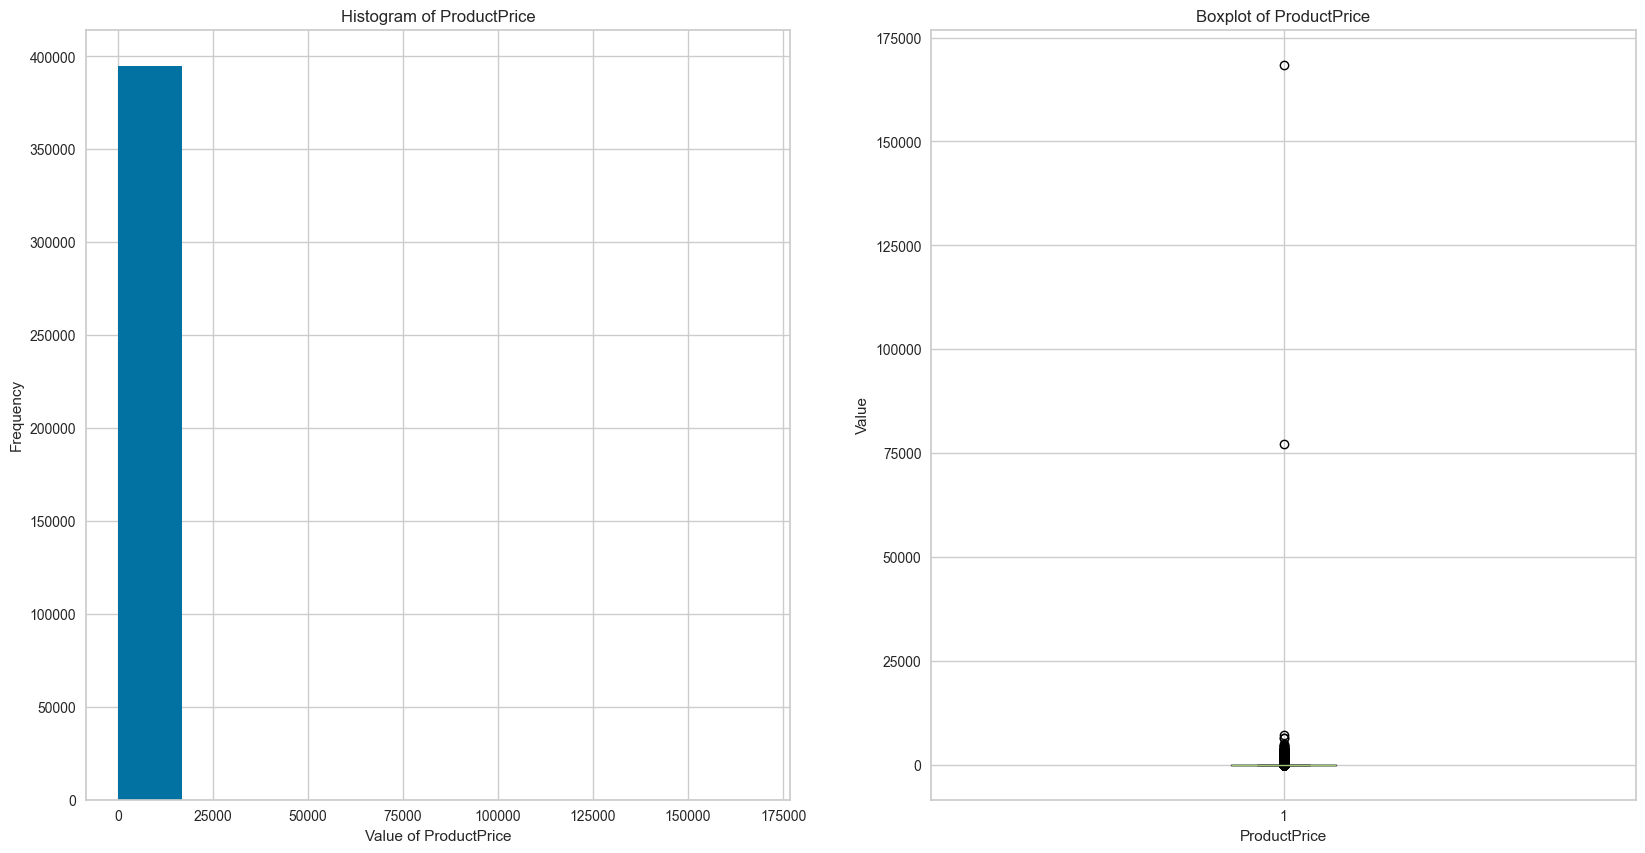

Number of Outliers: 31310
Percentage of Outliers 7.93%
Skewness: 475.74696094901236
Kurtosis: 251384.97132936332
Shapiro: 0.011691164200969384 | p_value: 3.602295038010879e-220 



count   394611.00
mean        22.55
std        303.40
min          0.00
25%          4.95
50%         12.50
75%         19.80
max     168469.60
Name: ProductPrice, dtype: float64

******************************************************************************************************************************************************
OrderPrice:


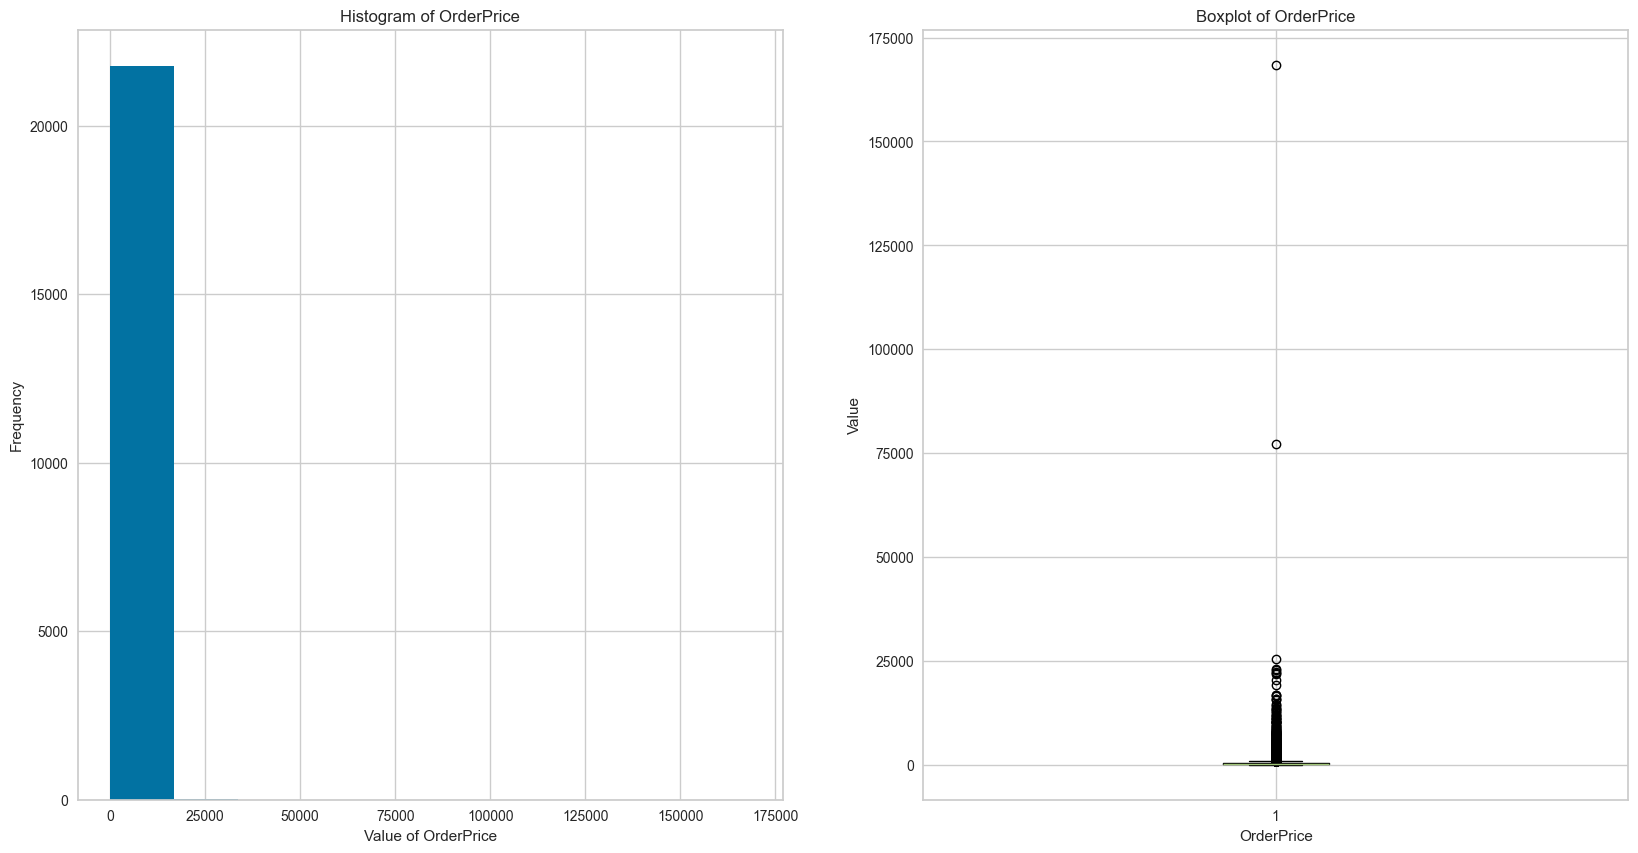

Number of Outliers: 1581
Percentage of Outliers 7.26%
Skewness: 69.51685501290653
Kurtosis: 7072.998704619117
Shapiro: 0.1209731011587536 | p_value: 1.2939278463767326e-134 



count   394611.00
mean       722.95
std       1425.75
min          0.38
25%        243.22
50%        385.56
75%        682.17
max     168469.60
Name: OrderPrice, dtype: float64

******************************************************************************************************************************************************
OrderQuantity:


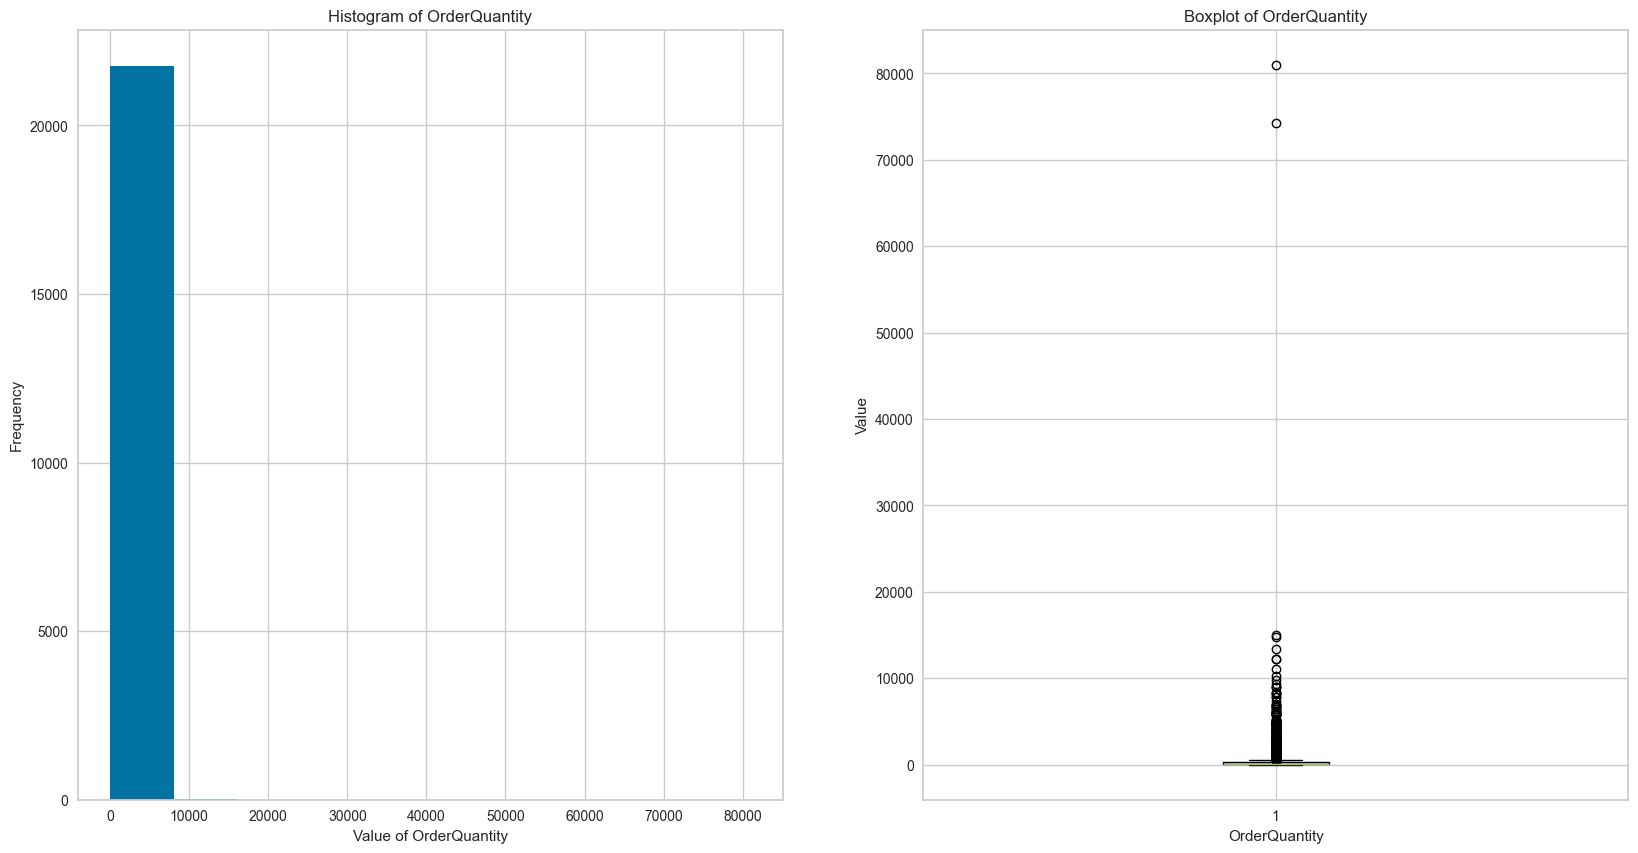

Number of Outliers: 1480
Percentage of Outliers 6.8%
Skewness: 60.98032175167815
Kurtosis: 5121.844913136173
Shapiro: 0.13174368250301383 | p_value: 2.968820280363509e-134 



count   394611.00
mean       428.80
std        875.34
min          1.00
25%        129.00
50%        236.00
75%        430.00
max      80995.00
Name: OrderQuantity, dtype: float64

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Customers Dataframe
******************************************************************************************************************************************************
CustomerOrdersTotal:


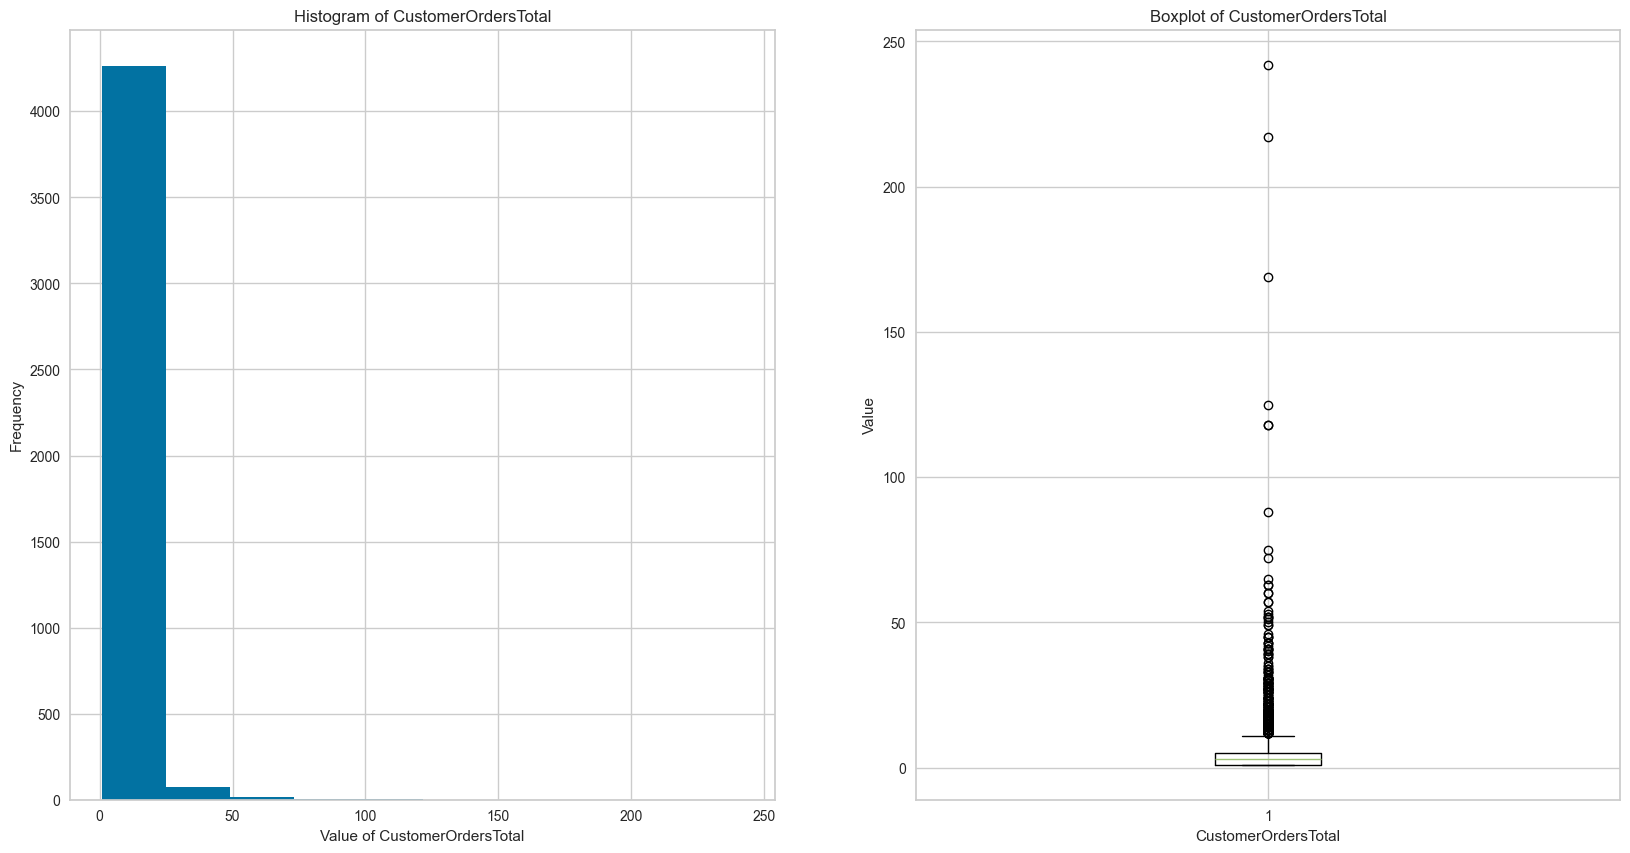

Number of Outliers: 386
Percentage of Outliers 8.86%
Skewness: 11.447709267448769
Kurtosis: 222.94373280117577
Shapiro: 0.3809904497950958 | p_value: 1.947267240221249e-81 



count   4358.00
mean       4.99
std        9.08
min        1.00
25%        1.00
50%        3.00
75%        5.00
max      242.00
Name: CustomerOrdersTotal, dtype: float64

******************************************************************************************************************************************************
OrderPrice:


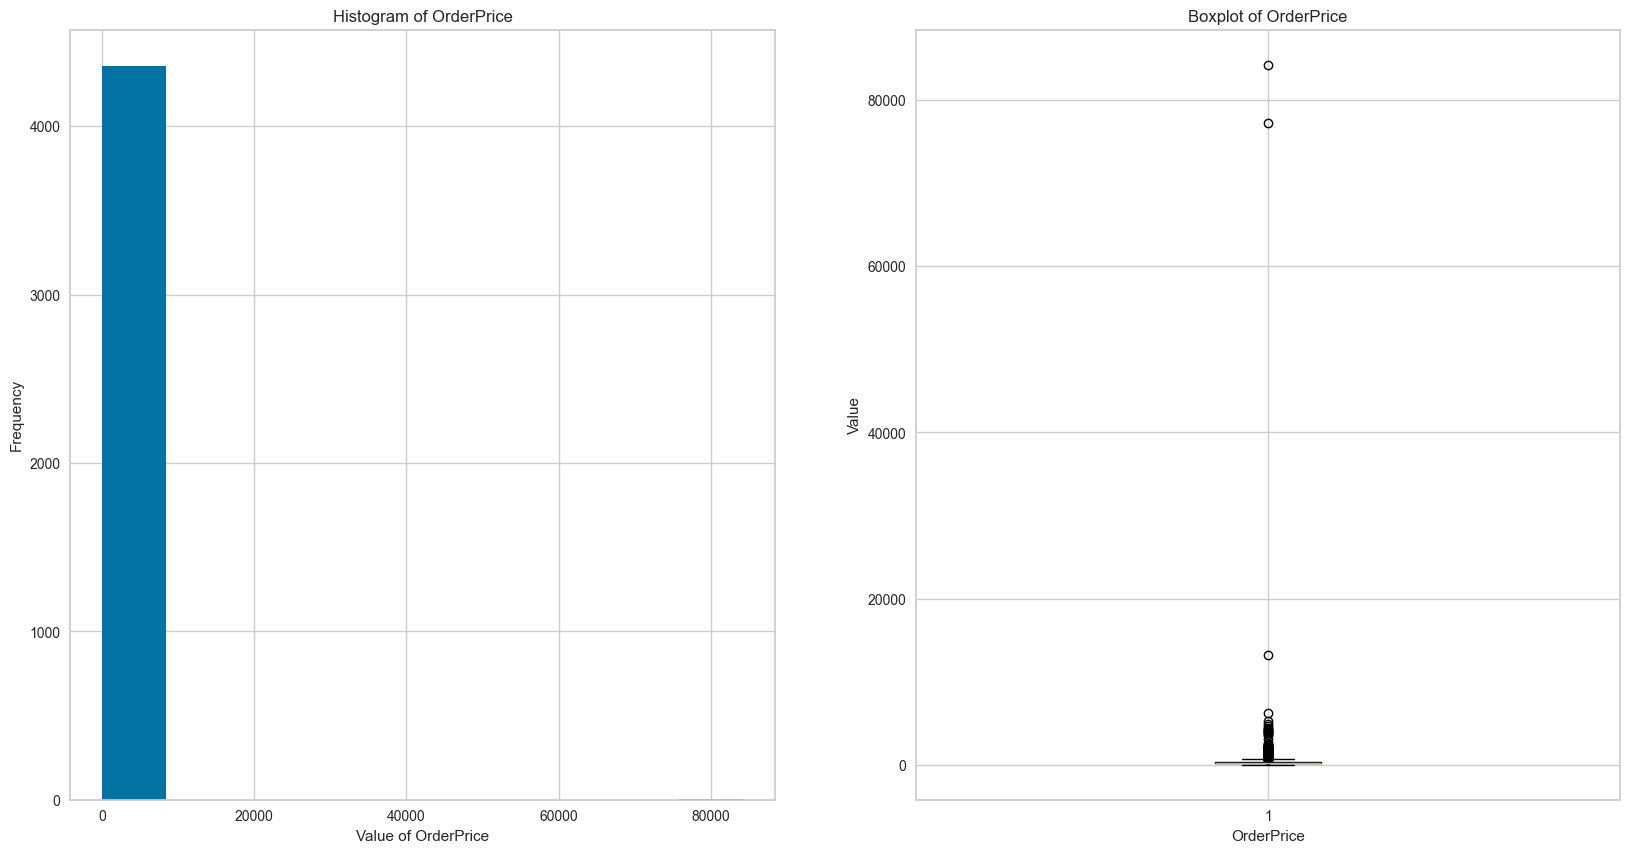

Number of Outliers: 299
Percentage of Outliers 6.86%
Skewness: 43.246980301311716
Kurtosis: 1964.8644869298273
Shapiro: 0.05136009973193467 | p_value: 5.677415879865249e-91 



count    4358.00
mean      369.49
std      1770.96
min         1.25
25%       160.45
50%       246.15
75%       376.80
max     84236.25
Name: OrderPrice, dtype: float64

******************************************************************************************************************************************************
OrderQuantity:


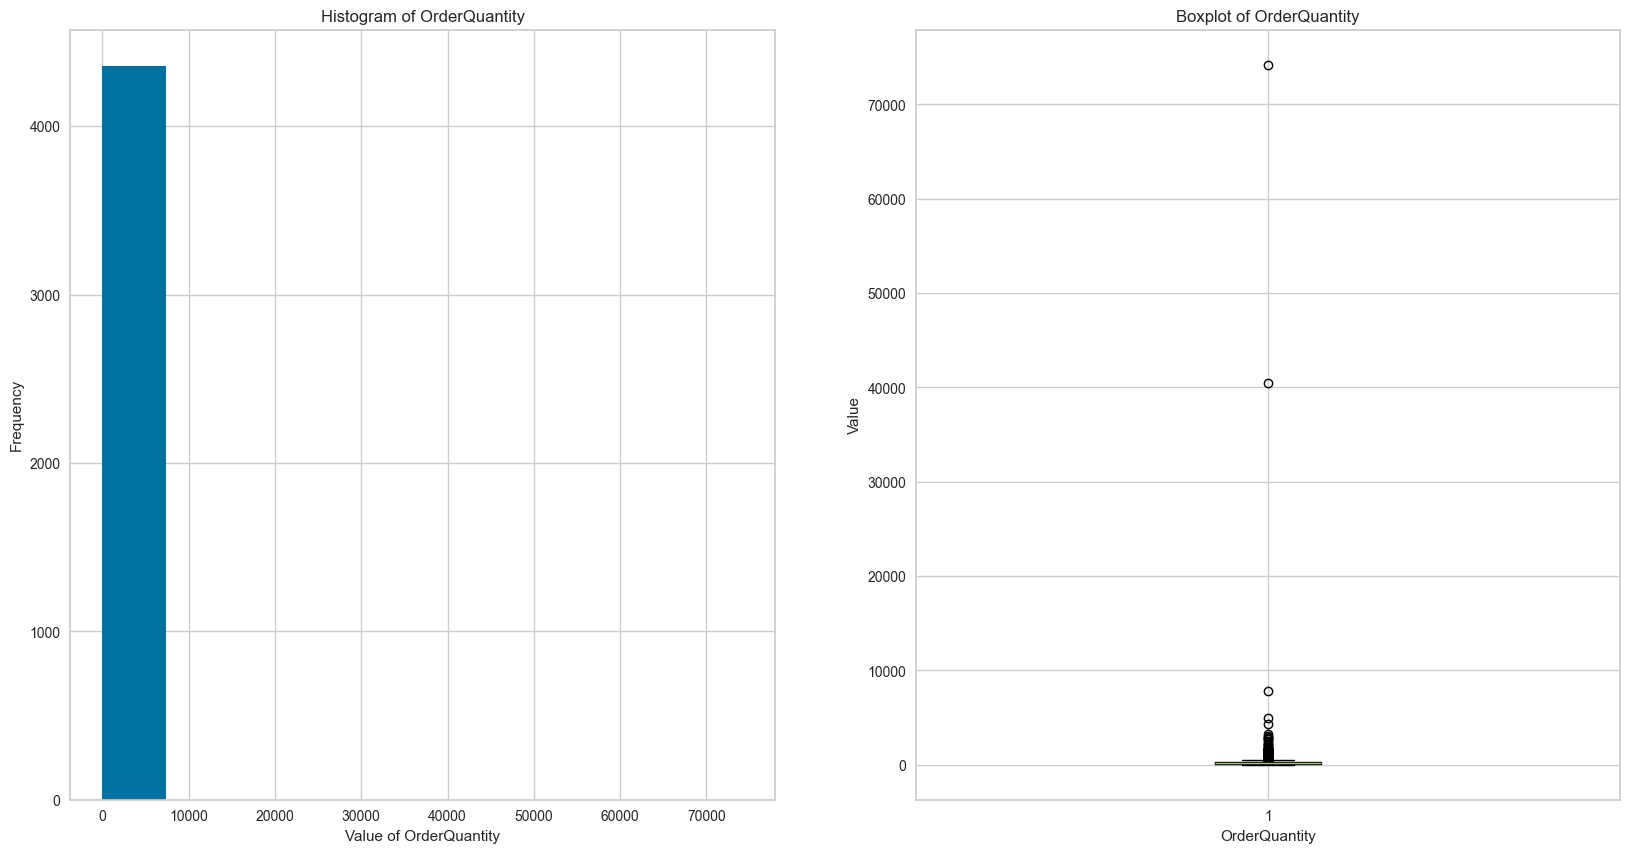

Number of Outliers: 287
Percentage of Outliers 6.59%
Skewness: 48.67159639334757
Kurtosis: 2577.914114652199
Shapiro: 0.04586724947960785 | p_value: 4.183134828084255e-91 



count    4358.00
mean      228.95
std      1304.92
min         1.00
25%        82.00
50%       142.50
75%       239.00
max     74215.00
Name: OrderQuantity, dtype: float64

In [29]:
# Numerical Variables Distribution
print("\\" * 150 + "\nFeatures Dataframe")
print("*" * 150 + f"\nProductPrice:")
distribution(df_features["ProductPrice"])
display(df_features["ProductPrice"].describe())

df_temp_unique_invoice = df_features.drop_duplicates("InvoiceNo")
print("*" * 150 + f"\nOrderPrice:")
distribution(df_temp_unique_invoice["OrderPrice"])
display(df_features["OrderPrice"].describe())
print("*" * 150 + f"\nOrderQuantity:")
distribution(df_temp_unique_invoice["OrderQuantity"])
display(df_features["OrderQuantity"].describe())

print("\\" * 150 + "\nCustomers Dataframe")
temp_cols = ["CustomerOrdersTotal", "OrderPrice", "OrderQuantity"]
for col in temp_cols:
       print("*" * 150 + f"\n{col}:")
       distribution(df_customer[col])
       display(df_customer[col].describe())


del temp_cols

In [30]:
# Categorical Variables Distribution & Time Between Orders
print("\\" * 150 + "\nFeatures Dataframe")
print("*" * 150 + f"\nSeason:")
display(df_temp_unique_invoice.value_counts("Season"))
print("*" * 150 + f"\nTimeDay:")
display(df_temp_unique_invoice.value_counts("TimeDay"))

print("\\" * 150 + "\nCustomers Dataframe")
print("*" * 150 + f"\nSeason:")
display(df_customer.value_counts("Season"))

del df_temp_unique_invoice

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Features Dataframe
******************************************************************************************************************************************************
Season:


Season
Autumn    7276
Winter    5002
Spring    4749
Summer    4740
Name: count, dtype: int64

******************************************************************************************************************************************************
TimeDay:


TimeDay
Afternoon    14216
Morning       7524
Night           27
Name: count, dtype: int64

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
Customers Dataframe
******************************************************************************************************************************************************
Season:


Season
Autumn    1877
Winter     890
Spring     838
Summer     753
Name: count, dtype: int64

,CustomerOrdersTotal,OrderPrice,OrderQuantity,UnitPrice
CustomerOrdersTotal,1.00,0.01,0.00,0.50
OrderPrice,0.01,1.00,0.94,-0.04
OrderQuantity,0.00,0.94,1.00,-0.04
UnitPrice,0.50,-0.04,-0.04,1.00


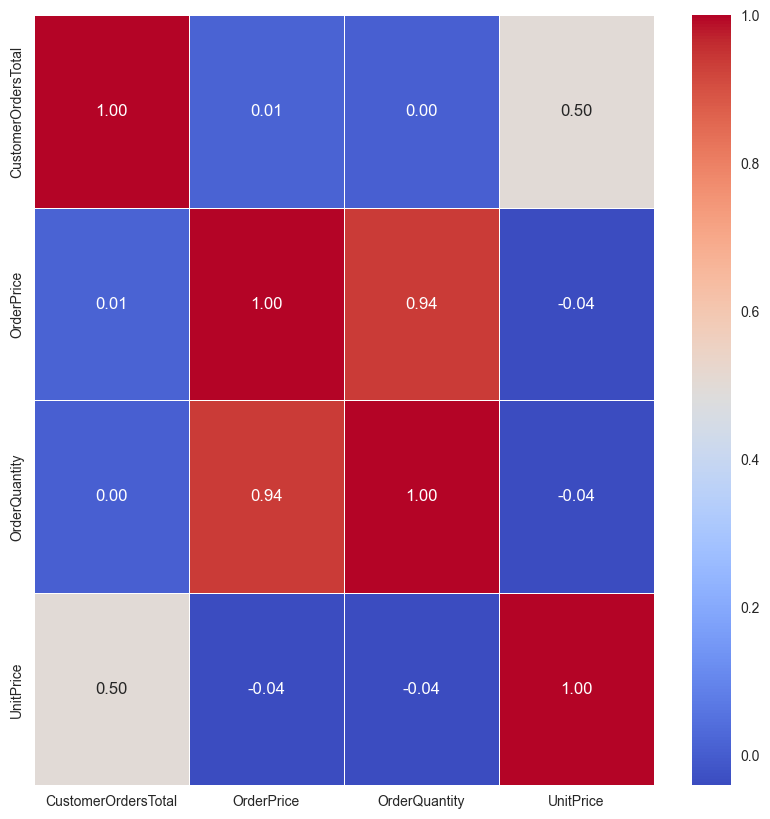

In [31]:
# Correlation Analysis
df_corr = df_customer.drop(columns=["CustomerID", "Country", "Season", "TimeDay", "TimeBetweenOrders"])
correlation_matrix = df_corr.corr()
display(correlation_matrix)
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            linewidths=.5, cbar=True)
plt.show()

del df_corr, correlation_matrix

#### Q1.2 Please describe in two paragraphs the main data insights. Connect the insight with the business  (10 points)


The dataset has a extensive record of e-commerce transactions, mostly buying but some returns as well, from December 2010 to December 2011. 90% of customers are from the UK, followed by other European countries such as Germany and France.
Most orders range from 250 to 700 in total price, and from 100 to 500 in quantity. For individual products, most unit prices range from 1.25 to 3.75 and quantities from 2 to 12. This indicates that most customers usually order a very large variety of items, with little of each item.

The correlation analysis also shows that each customer's previous number of orders does not affect their shopping, as this number has a very low correlation with the quantity of items ordered and the final price of the order. Regarding the specific products, both the distribution analysis and the inspection of the dataset shows a great diversity in the catalog, from cheap items that are bought in high numbers like a Ceramic Storage Jar (code 23166) to more expensive items bought in low quantities, such as furniture (e.g. 22656 - VINTAGE BLUE KITCHEN CABINET).

## Question 2: Segment the clients based on their purchase profile (35 points)

#### Q2.1 Build a baseline model to segment the costumers. (15 points)

In [32]:
# Prepare the data for clustering
# One Hot Encoding, with 0 and 1, for the Season and TimeDay Variables
df_customer_encoded = pd.get_dummies(df_customer, columns=["Season", "TimeDay"])
df_customer_encoded.iloc[:, 7:] = df_customer_encoded.iloc[:, 7:].astype("int")

# Convert TimeBetweenOrders to hours
df_customer_encoded["TimeBetweenOrders"] = pd.to_timedelta(df_customer_encoded["TimeBetweenOrders"])
df_customer_encoded["TimeBetweenOrders"] = df_customer_encoded["TimeBetweenOrders"].apply(
    lambda x: x.total_seconds() / 3600)

# Remove useless columns
df_customer_encoded = df_customer_encoded.drop(columns=["CustomerID", "Country"])

# Standardize the numerical data
scaler = StandardScaler()
df_customer_scaled = df_customer_encoded.copy()
df_customer_scaled.iloc[:, :5] = scaler.fit_transform(df_customer_scaled.iloc[:, :5])

display(df_customer_scaled.head())

,CustomerOrdersTotal,OrderPrice,OrderQuantity,UnitPrice,TimeBetweenOrders,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeDay_Afternoon,TimeDay_Morning,TimeDay_Night
0,3.30,-0.12,-0.14,5.45,-0.28,0,0,0,1,0,1,0
307,1.21,-0.09,-0.11,1.11,-0.15,0,0,1,0,1,0,0
501,1.32,0.02,0.05,0.06,-0.16,1,0,0,0,1,0,0
736,0.00,-0.10,-0.11,0.07,0.60,1,0,0,0,0,1,0
764,0.11,-0.10,-0.16,2.58,0.46,0,0,0,1,1,0,0


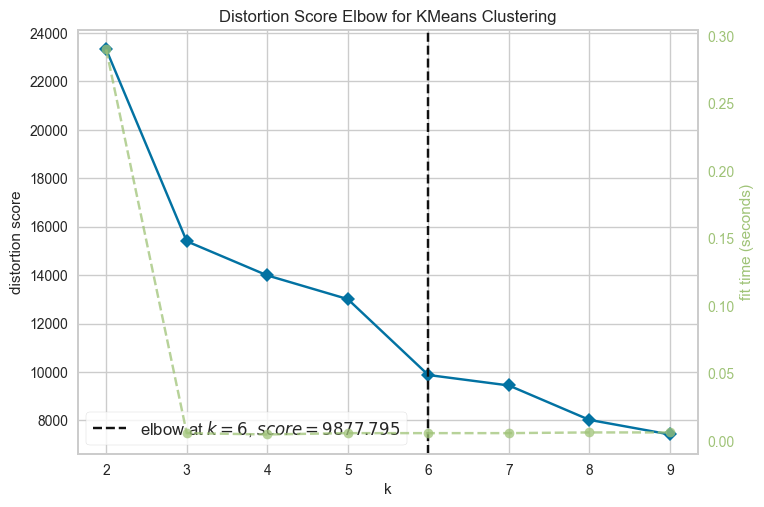

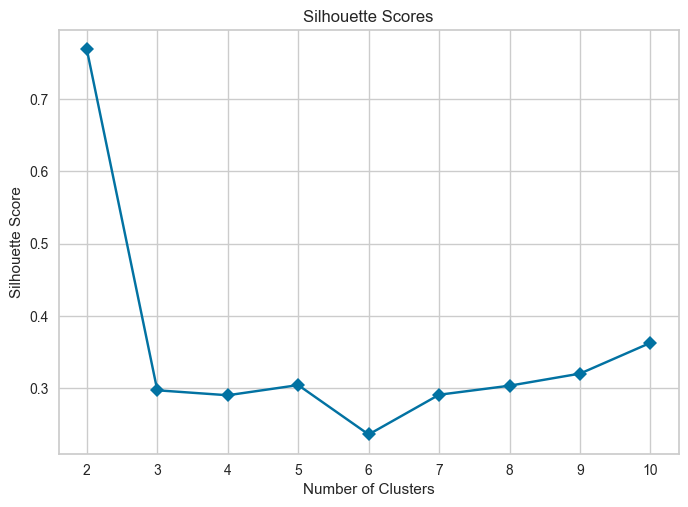

Cluster
2    3083
1    1273
0       2
Name: count, dtype: int64

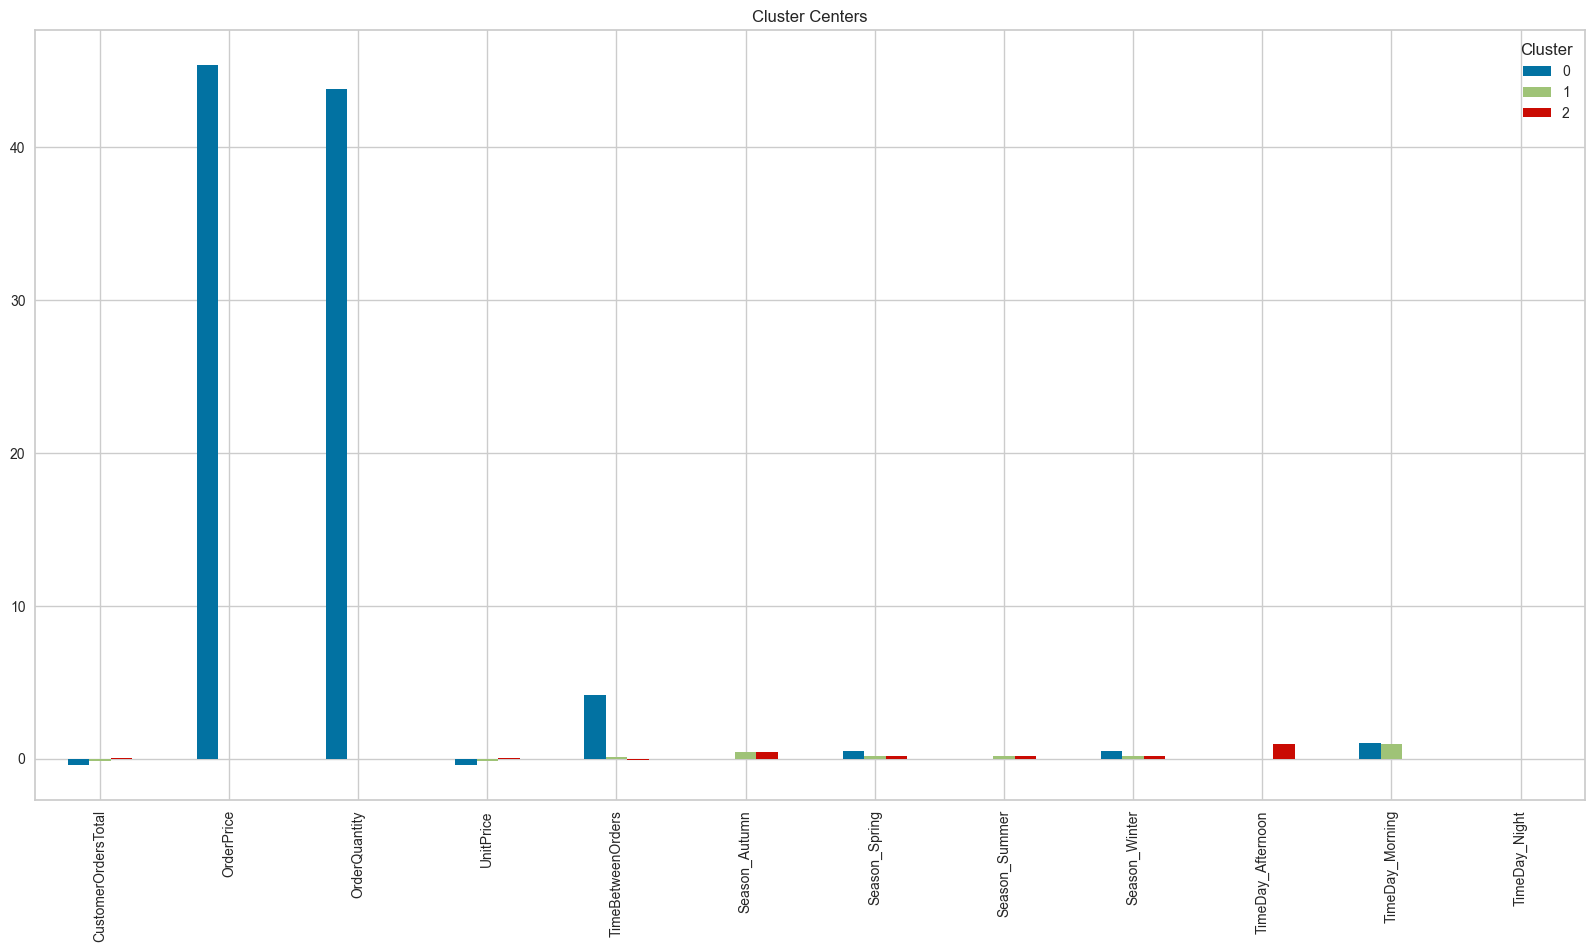

Silhouette Score: 0.2633418635598511


In [33]:
# Train Kmeans model
# Test the optimal K
# Elbow Method
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(df_customer_scaled)
visualizer.show()

# Silhouette Method
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_customer_scaled)
    silhouette_scores.append(silhouette_score(df_customer_scaled, kmeans.labels_))
plt.plot(range(2, 11), silhouette_scores, marker="D")
plt.title("Silhouette Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

# Train the model
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer_scaled)
df_customer_kmeans = df_customer_scaled.copy()
df_customer_kmeans["Cluster"] = kmeans.labels_
display(df_customer_kmeans["Cluster"].value_counts())

# Visualize Cluster Metrics (based on center)
df_cluster = df_customer_kmeans.groupby("Cluster").mean()
df_cluster = df_cluster.T
df_cluster.plot(kind="bar", figsize=(20, 10))
plt.title("Cluster Centers")
plt.show()

# Evaluate Model
print("Silhouette Score:", silhouette_score(df_customer_scaled, kmeans.labels_))

#### Q2.2 Build a second model to segment costumers and compare the performance. (10 points)

The first model has 3 clusters and a relatively low Silhouette Score of 0.2633418635598511. These clusters were set as hyperparameters based on the optimization process, but still produced bad results. The second model has 4 clusters, with the number of clusters being obtained from the DBSCAN algorithm. The second model has a way greater performance, with a Silhouette Score of 0.7589228845388297. The epsilon hyperparameter was also set after optimization.

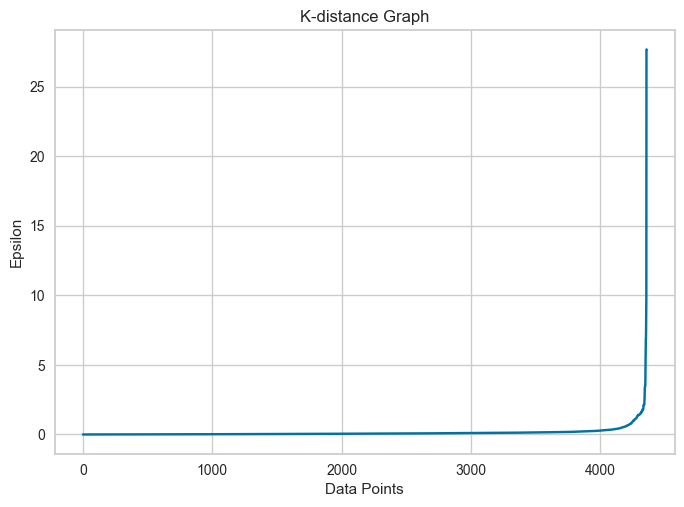

,0
4320,1.67
4321,1.68
4322,1.68
4323,1.68
4324,1.76
4325,1.76
4326,1.76
4327,1.81
4328,1.81
4329,1.82


Cluster
 0    4303
-1      40
 1      10
 2       5
Name: count, dtype: int64

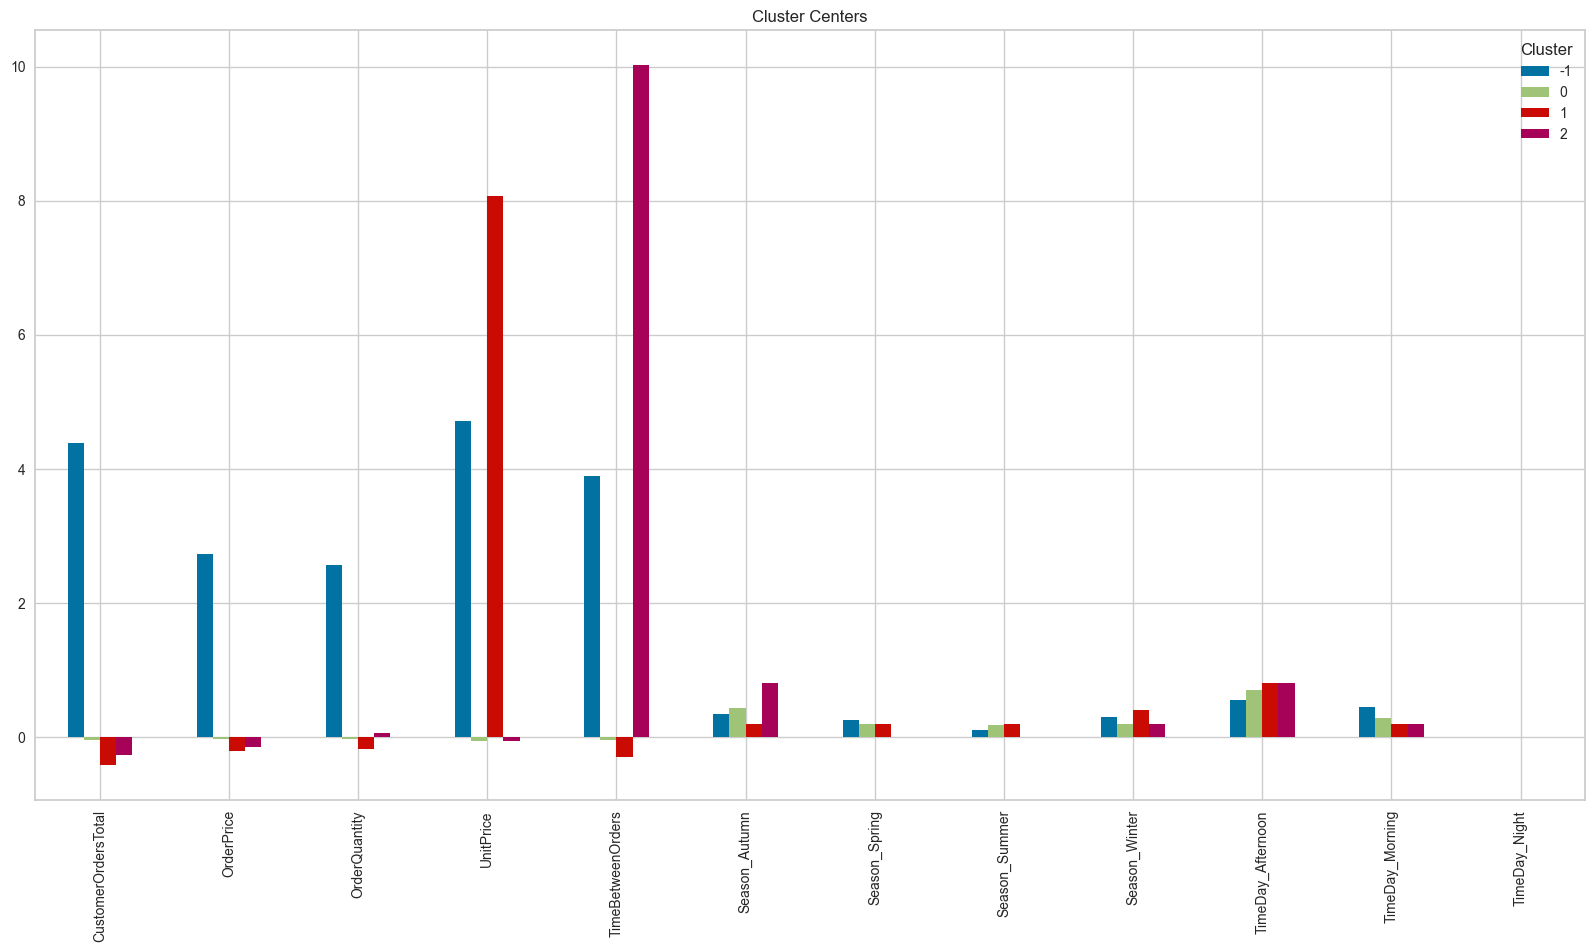

Silhouette Score: 0.7589228845388297


In [38]:
# Train DBSCAN model
# Test the optimal Epsilon
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_customer_scaled)
distances, indices = nbrs.kneighbors(df_customer_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Data Points")
plt.ylabel("Epsilon")
plt.show()
display(pd.DataFrame(distances).iloc[4320:].head(50))

# Train the model
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan.fit(df_customer_scaled)
df_customer_dbscan = df_customer_scaled.copy()
df_customer_dbscan["Cluster"] = dbscan.labels_
display(df_customer_dbscan["Cluster"].value_counts())

# Visualize Cluster Metrics (based on center)
df_cluster = df_customer_dbscan.groupby("Cluster").mean()
df_cluster = df_cluster.T
df_cluster.plot(kind="bar", figsize=(20, 10))
plt.title("Cluster Centers")
plt.show()

# Evaluate Model
print("Silhouette Score:", silhouette_score(df_customer_scaled, dbscan.labels_))

#### Q2.3 Based on the analysis, suggest a number of clusters and their characteristics to the head of marketing. Please justify your decisions. (10 points)

Although both models tested have more than two clusters, the visualization of the average characteristics of each cluster indicates that dividing the customers in two segments is a more accurate representation of reality, as using a higher number would make the segments too similar.

From the results of both models, we can conclude that all customers seem to have similar patterns regarding the time of order, both in seasonality and within the day. What distinguishes the two segments the most are the total number of orders, the order price, the order quantity, the unit price and the Time between orders.

For the first segment, customers have a higher total number of orders, higher order price, higher quantity and time between orders; while in the other segment the only thing higher is the UnitPrice. We can think of the first segment as regular customers, who probably rely on the company for their regular supplying activities, while the other segment has customers that are relatively newer, and only use the platform for one time purchases of specific items that are hard to buy locally (hence the higher unit price).

Due to these characteristics, it is clear the the first segment has customers with a higher lifetime value and loyalty, while the other customers have less value but are also more likely to shop somewhere else. So, if the marketing department wants to expand the customer base, it should look to invest in campaigns that attract the second segment, while if the marketing department wants to retain market share, it must prioritize customers from the first segment.

## Question 3: Create a recommendation system that helps the company to increase sales (35 points)


#### Q3.1 Build the recommendation system. (25 points)

In [35]:
# Prepare the features for the recommendation system
interaction_matrix = df_features.pivot_table(
    index="CustomerID", 
    columns="StockCode", 
    values="Quantity",  # We use quantity to give more weight to products that were bought more
    aggfunc="sum", 
    fill_value=0
)
# Normalize the quantity values, within each product
interaction_matrix = interaction_matrix.apply(lambda x: (x - x.mean()) / (x.std()),
                                               axis=0).fillna(0)
display(interaction_matrix)

# Train Model
item_similarity = cosine_similarity(interaction_matrix.T)
item_similarity = pd.DataFrame(item_similarity, index=interaction_matrix.columns,
                               columns=interaction_matrix.columns)

df_descriptions = df_features[["StockCode", "Description"]].drop_duplicates().set_index("StockCode")

def get_recommendation(stock_code: str, top_n: int = 10) -> pd.DataFrame:
    """
    Get the top N recommendations for a specific product (default top 10)
    
    Parameters
    ---------------
    stock_code: str
        Stock code of the product evaluated
    top_n: int
        Number of recommendations to be returned
 
    Returns
    ---------------
    recommendations: pd.DataFrame
        A dataframe with the top N recommendations for the product, with the
        associated similarity scores
    
    """
    recommendations = item_similarity[stock_code].sort_values(ascending=False
                                                ).to_frame().head(11).iloc[1:]
    recommendations = recommendations.join(df_descriptions, how="left"
                                           ).rename(columns={stock_code:"Similarity"})

    return recommendations

display(get_recommendation("11001"))

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214P,90214R,90214S,90214T,90214U,90214V,90214W,90214Y,90214Z,PADS
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03
12347,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03
12348,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03
12349,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03
12350,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03
18281,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03
18282,-0.04,-0.04,-0.05,-0.02,-0.03,-0.03,-0.04,-0.10,-0.08,-0.03,...,-0.02,-0.02,-0.03,-0.02,-0.02,-0.02,-0.02,-0.02,-0.02,-0.03


,Similarity,Description
StockCode,,
22191,0.97,IVORY DINER WALL CLOCK
23215,0.96,JINGLE BELL HEART ANTIQUE SILVER
22991,0.96,GIRAFFE WOODEN RULER
22493,0.96,PAINT YOUR OWN CANVAS SET
21479,0.93,WHITE SKULL HOT WATER BOTTLE
20829,0.91,GLITTER HANGING BUTTERFLY STRING
22992,0.91,REVOLVER WOODEN RULER
22564,0.89,ALPHABET STENCIL CRAFT
22604,0.88,SET OF 4 NAPKIN CHARMS CUTLERY


#### Q3.2 Based on the analysis, suggest how the model can be used in marketing. Which data would you like to have to improve the results? Please justify your decisions. (10 points)

Based on the available data, a Collaborative Filtering, user-item based approach was adopted. In this approach, our recommendations will be made based on the products that the consumers of one product also consume. This has the advantage of being easier to implement and being able to explain the results obtained.

The marketing department can use our model in order to, based on past purchases of an user, recommend new items that similar users also ordered. This would increase the likelihood of the customer reordering new items.

However, this approach can be vulnerable to issues such as a bias towards more popular items (Popularity Bias). Additionally, since we make use of the quantity consumed of the product has an enhancer, this also introduces a bias towards items that by nature are ordered in high quantities (e.g. school materials), and against items ordered in small quantities (e.g. furniture). Finally, although the dataset is relatively contained in terms of time, only spanning for a year, items introduced more recently will also be less recommended (Cold-start problem).

Because of these problems, we should get more data regarding the products being sold to implement content-based elements in our recommendation systems, since the description is very limited; get rating data (since our dataset does not include any satisfaction metric for the orders and instead quantity is used as a substitute, which introduces bias) for the products and demographic data for the customers to improve the item-based system already developed.